**Table of contents**<a id='toc0_'></a>    
- [Process inputs](#toc1_)    
- [Read and Prep data](#toc2_)    
- [Create models](#toc3_)    
  - [Train model limiting no interaction](#toc3_1_)    
    - [Predict and evaluate](#toc3_1_1_)    
  - [Train model 2nd layer to just find 2 way interactions](#toc3_2_)    
    - [Evaluate](#toc3_2_1_)    
  - [Train 3 model and evaluate](#toc3_3_)    
- [Feature importance](#toc4_)    
  - [Feature importance main effects](#toc4_1_)    
  - [Feature importance 2 way interactions](#toc4_2_)    
  - [Feature importance 3 way interactions](#toc4_3_)    
- [Model Iterrogation](#toc5_)    
  - [Calc shap values](#toc5_1_)    
- [Contribution plots](#toc6_)    
- [Interaction analysis](#toc7_)    
  - [Main interactions](#toc7_1_)    
  - [Interaction plots](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
import pandas as pd
import lightgbm as lgb
from func import calculate_prediction_quality, calculate_ranking_metrics, get_feature_importance

# <a id='toc1_'></a>[Process inputs](#toc0_)

In [5]:
target = 'qualidade_global_media_dada_pela_equipe'
categorical_features = ['laboratorio', 'fora_de_tipo_x_tipo_unico']
data_path = "../data/processed/df_model_v02.parquet"

# <a id='toc2_'></a>[Read and Prep data](#toc0_)

In [6]:
data = pd.read_parquet(data_path)

# Turn categorical variables to categorical type for lightgbm split variables as categorical
for cat_var in categorical_features:
    data[cat_var] = pd.Categorical(data[cat_var])

# Isolate and remove response column from data
response = data[target].values
trn_data = data.drop(columns=[target])

# Create lgbm dataset
trn_dset = lgb.Dataset(trn_data, label=response, params={'max_bin': 5000})

# <a id='toc3_'></a>[Create models](#toc0_)

## <a id='toc3_1_'></a>[Train model limiting no interaction](#toc0_)

In [7]:
mdl = lgb.train(params={"objective":"regression", 
                        "num_boost_round":10000, 
                        "max_depth":1, 
                        "learning_rate":1,
                        'max_bin': 5000,
                        "verbose":-1
                        }, train_set=trn_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### <a id='toc3_1_1_'></a>[Predict and evaluate](#toc0_)

In [8]:
prd = mdl.predict(trn_data)
calculate_prediction_quality(list(response),list(prd))

{'rmse': 0.09101779254910536,
 'mae': 0.0701254684562258,
 'r2': 0.9955829366577275,
 'gini': 0.12622071215762853}

## <a id='toc3_2_'></a>[Train model 2nd layer to just find 2 way interactions](#toc0_)

In [9]:
int_dset = lgb.Dataset(trn_data, label=response, init_score=prd)

int_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":2, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### <a id='toc3_2_1_'></a>[Evaluate](#toc0_)

In [10]:
int_prd = int_mdl.predict(trn_data) + prd
calculate_prediction_quality(list(response),list(int_prd))

{'rmse': 0.0023295742179967683,
 'mae': 0.001423175898107974,
 'r2': 0.9999971064290684,
 'gini': 0.12658850028001778}

## <a id='toc3_3_'></a>[Train 3 model and evaluate](#toc0_)

In [11]:
int3_dset = lgb.Dataset(trn_data, label=response, init_score=int_prd)

int3_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":3, 
                            "learning_rate":1, 
                            "extra_trees" :True,
                            "verbose":-1}, 
                            train_set=int3_dset)

/Users/caiosainvallio/miniconda3/envs/coffeetree/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [12]:
int3_prd = int3_mdl.predict(trn_data) + int_prd
calculate_prediction_quality(list(response),list(int3_prd))

{'rmse': 6.326849373643438e-06,
 'mae': 2.76820020165831e-06,
 'r2': 0.999999999978657,
 'gini': 0.12658850028001778}

In [13]:
calculate_ranking_metrics(list(response),list(int3_prd))

{'spearman_correlation': 0.9990218291159184,
 'kendall_tau': 0.9851730116676112,
 'ranking_error': 0.014811556458585711,
 'ordering_accuracy': 0.9726328689821319}

# <a id='toc4_'></a>[Feature importance](#toc0_)
## <a id='toc4_1_'></a>[Feature importance main effects](#toc0_)

In [14]:
main_imp = get_feature_importance(mdl,trn_data.columns)
main_imp

gain
Feature                         
acidez_intensidade          1654
docura                      1407
amargor                     1351
acidez_qualidade            1209
intensidade                 1171
adstringencia               1090
odor_do_po                   913
corpo                        644
baunilha                      50
queimado_defumado             49
amendoado_castanhas           46
frutado                       43
fermentado                    41
laboratorio                   40
chocolate_cacau               38
cedro_carvalho_amadeirado     31
terroso_mofo                  30
madeira_papelao               28
tostado                       21
mel                           20
floral                        19
azedo                         17
velho_oxidado                 17
caramelizado_caramelo_doce    16
fora_de_tipo_x_tipo_unico     12
vegetal                       12
verde                         10
especiarias                    6
iodoformio_quimico             6
borracha                       6
cereal                         3
cozido_assado                  0
animalico_curral               0
alcoolico                      0
herbaceo                       0

## <a id='toc4_2_'></a>[Feature importance 2 way interactions](#toc0_)

In [15]:
int_imp = get_feature_importance(int_mdl,trn_data.columns)
int_imp

gain
Feature                         
odor_do_po                  1805
intensidade                 1792
amargor                     1620
corpo                       1555
acidez_intensidade          1554
adstringencia               1490
acidez_qualidade            1419
chocolate_cacau             1409
velho_oxidado               1379
queimado_defumado           1349
docura                      1348
tostado                     1293
madeira_papelao             1267
laboratorio                 1047
caramelizado_caramelo_doce   922
frutado                      844
terroso_mofo                 708
amendoado_castanhas          646
borracha                     610
fora_de_tipo_x_tipo_unico    599
cereal                       534
mel                          491
verde                        485
cedro_carvalho_amadeirado    456
iodoformio_quimico           414
baunilha                     384
fermentado                   381
floral                       302
especiarias                  164
vegetal                      112
azedo                         59
animalico_curral               0
cozido_assado                  0
alcoolico                      0
herbaceo                       0

## <a id='toc4_3_'></a>[Feature importance 3 way interactions](#toc0_)

In [16]:
get_feature_importance(int3_mdl,trn_data.columns)

gain
Feature                         
madeira_papelao             4377
chocolate_cacau             4352
velho_oxidado               4213
queimado_defumado           3913
odor_do_po                  3350
tostado                     2847
intensidade                 2801
corpo                       2603
amargor                     2431
adstringencia               2374
acidez_intensidade          2346
acidez_qualidade            2182
docura                      2072
frutado                     1676
fora_de_tipo_x_tipo_unico   1655
caramelizado_caramelo_doce  1624
borracha                    1491
laboratorio                 1452
terroso_mofo                1099
amendoado_castanhas          925
iodoformio_quimico           823
mel                          813
cedro_carvalho_amadeirado    685
verde                        636
baunilha                     521
cereal                       495
floral                       428
fermentado                   392
especiarias                  144
vegetal                      140
azedo                        135
alcoolico                      0
animalico_curral               0
cozido_assado                  0
herbaceo                       0

# <a id='toc5_'></a>[Model Iterrogation](#toc0_)

## <a id='toc5_1_'></a>[Calc shap values](#toc0_)

In [17]:
from shap import TreeExplainer

exp = TreeExplainer(mdl)
shap = exp.shap_values(trn_data)

shap_df = pd.DataFrame(shap, columns=trn_data.columns)
shap_df

laboratorio  fora_de_tipo_x_tipo_unico  odor_do_po    docura     corpo  \
0       0.052826                   0.027273    0.041328  0.503212  0.212460   
1       0.052826                   0.027273   -0.052805  0.503212  0.287266   
2       0.052826                   0.027273   -0.017593  0.458613  0.272560   
3       0.052826                   0.027273   -0.017593  0.503212  0.287266   
4       0.052826                   0.027273   -0.146067  0.423730  0.212460   
..           ...                        ...         ...       ...       ...   
922    -0.349518                   0.027273   -0.128184 -0.038432 -0.262583   
923    -0.349518                   0.027273   -0.085815  0.018416 -0.087988   
924    -0.349518                   0.027273   -0.146067 -0.040054  0.144781   
925    -0.349518                   0.027273    0.030021 -0.038432 -0.205990   
926    -0.349518                   0.027273    0.254652 -0.191281 -0.162961   

     acidez_intensidade  acidez_qualidade   amargor  adstringencia  \
0             -0.012328          0.668564  0.027251       0.230430   
1             -0.012328          0.697634  0.039515       0.243428   
2              0.093275          0.697634 -0.032545       0.243428   
3              0.147342          0.686258 -0.040578       0.275468   
4              0.001782          0.697634 -0.032545       0.324971   
..                  ...               ...       ...            ...   
922            0.225051          0.026211  0.088500      -0.201005   
923            0.079223         -0.024092  0.033841       0.019789   
924           -0.203394          0.026211  0.048182      -0.251254   
925            0.049699          0.026211  0.039380      -0.297956   
926            0.079223         -0.213940 -0.001373      -0.251254   

     intensidade  ...  iodoformio_quimico  madeira_papelao       mel  \
0       0.237792  ...            0.004449        -0.029222 -0.006929   
1       0.076254  ...            0.004449        -0.029222 -0.006929   
2       0.082757  ...            0.004449        -0.029222 -0.006929   
3       0.082757  ...            0.004449        -0.029222 -0.006929   
4       0.237792  ...            0.004449        -0.029222  0.027921   
..           ...  ...                 ...              ...       ...   
922     0.071035  ...            0.004449         0.080705 -0.006929   
923     0.076254  ...            0.004449        -0.029222 -0.006929   
924     0.237792  ...            0.004449         0.009834 -0.006929   
925    -0.079021  ...            0.004449         0.074864 -0.006929   
926     0.047346  ...            0.004449        -0.029222 -0.006929   

     queimado_defumado  terroso_mofo   tostado   vegetal  velho_oxidado  \
0             0.006092      0.010701 -0.001793 -0.001255       0.004069   
1             0.006092      0.010701 -0.001793 -0.001255       0.004069   
2             0.006092      0.010701 -0.001793 -0.001255       0.004069   
3             0.006092      0.010701 -0.001793 -0.001255       0.004069   
4             0.006092      0.010701 -0.001793 -0.001255       0.004069   
..                 ...           ...       ...       ...            ...   
922           0.018127     -0.044720 -0.001793 -0.001255       0.004069   
923           0.018127      0.010701 -0.001793 -0.001255       0.004069   
924           0.009536     -0.044720 -0.001793 -0.001255       0.004069   
925           0.006092      0.010701 -0.001793 -0.001255      -0.021478   
926           0.018127      0.010701 -0.001793 -0.001255      -0.006513   

        verde  herbaceo  
0    0.008934       0.0  
1    0.008934       0.0  
2    0.008934       0.0  
3    0.008934       0.0  
4    0.008934       0.0  
..        ...       ...  
922  0.008934       0.0  
923  0.008934       0.0  
924  0.008934       0.0  
925  0.008934       0.0  
926  0.008934       0.0  

[927 rows x 35 columns]

# <a id='toc6_'></a>[Contribution plots](#toc0_)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


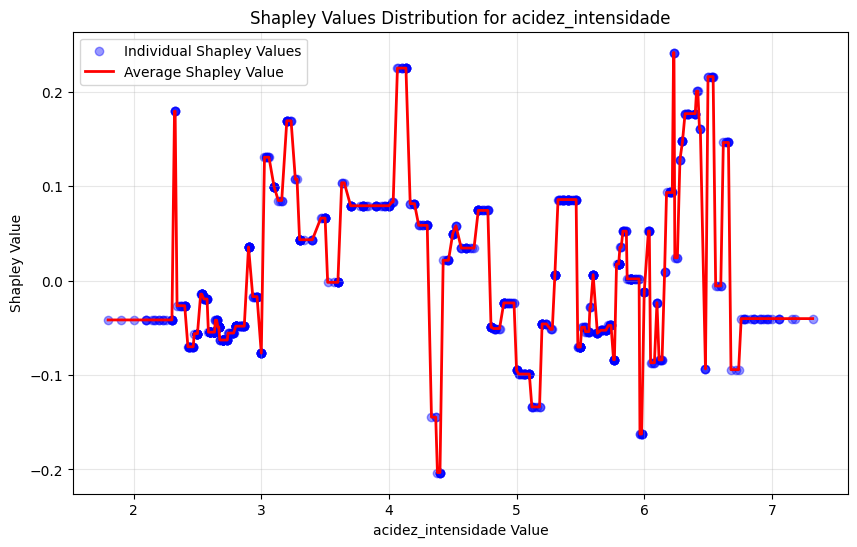

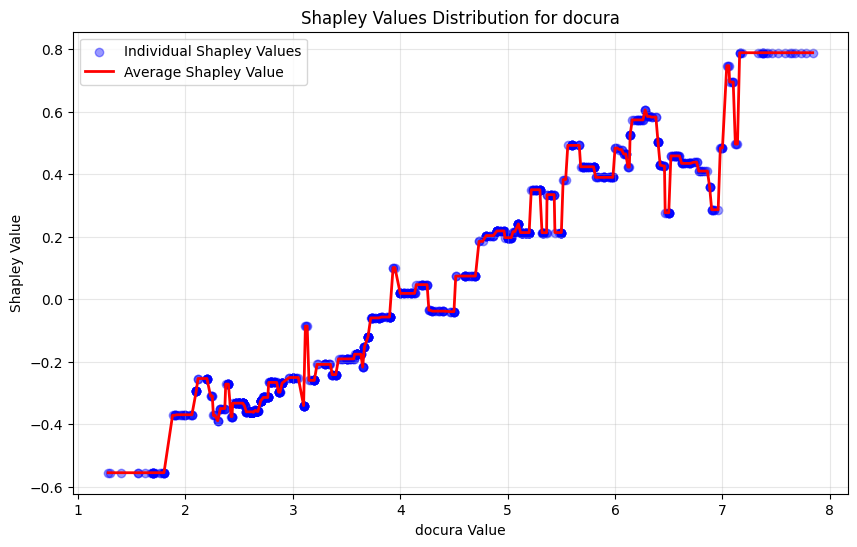

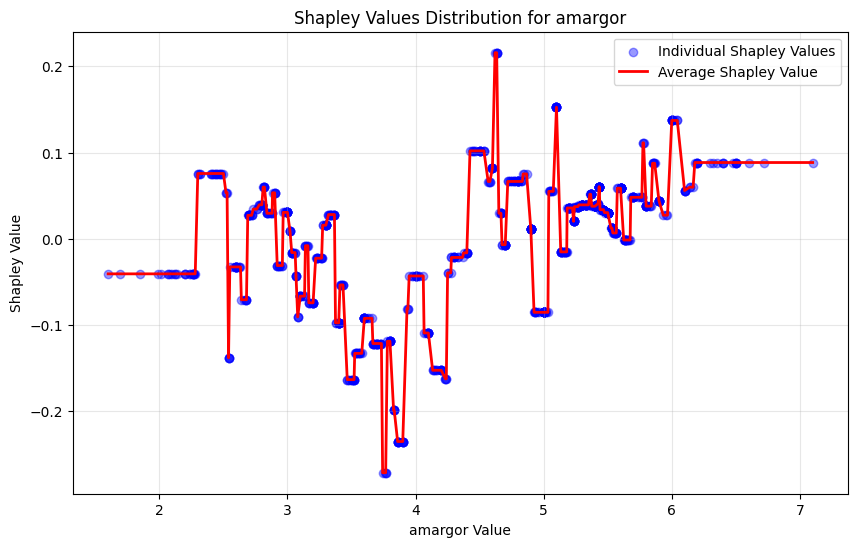

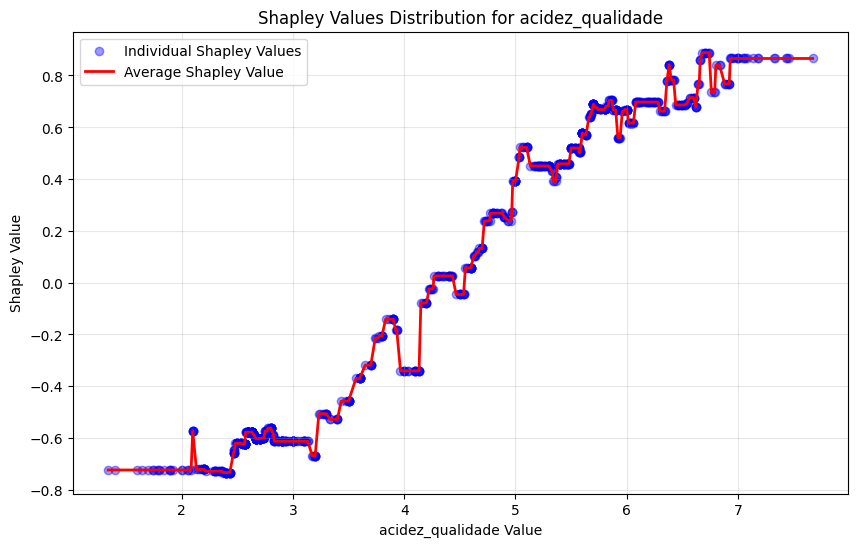

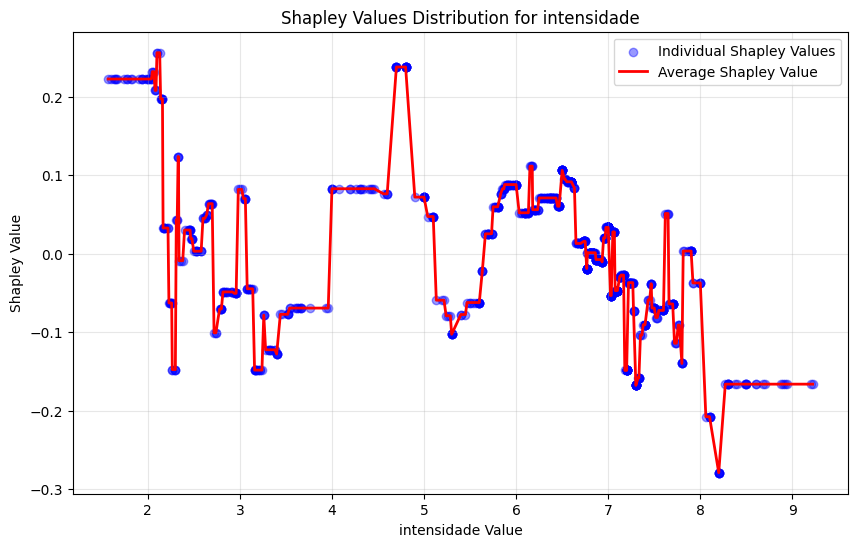

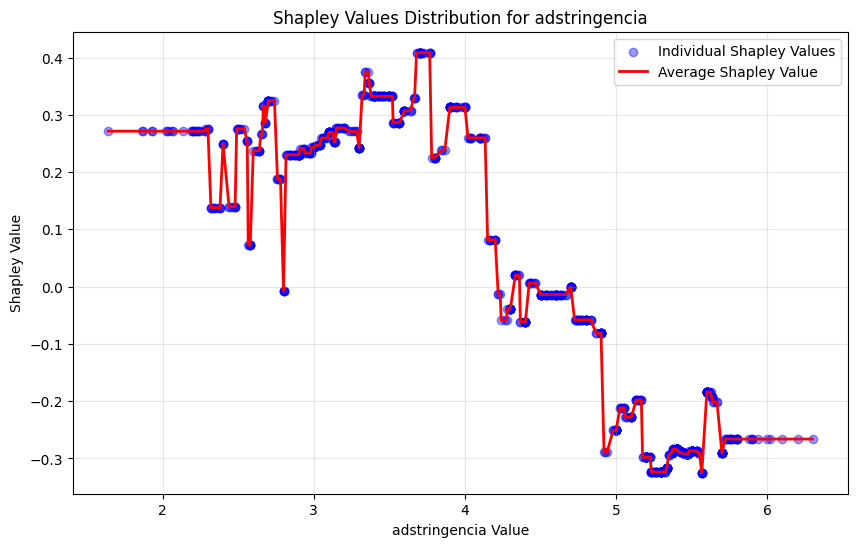

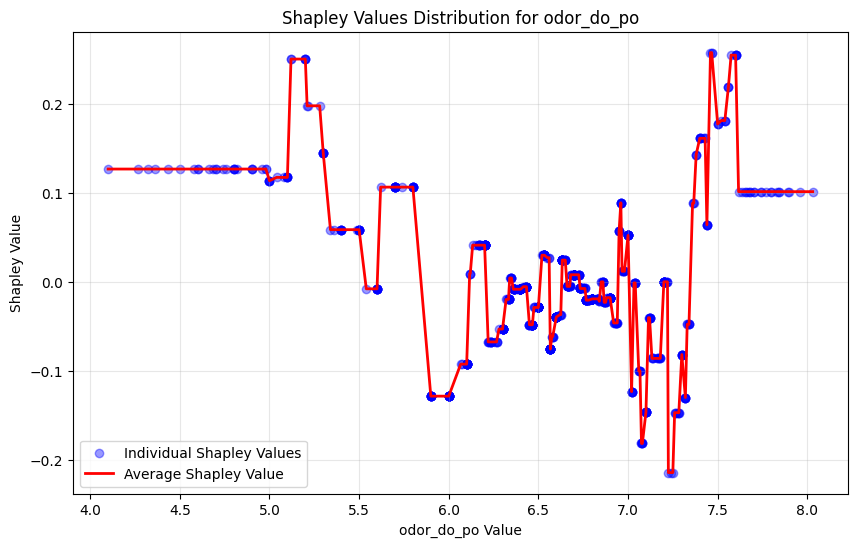

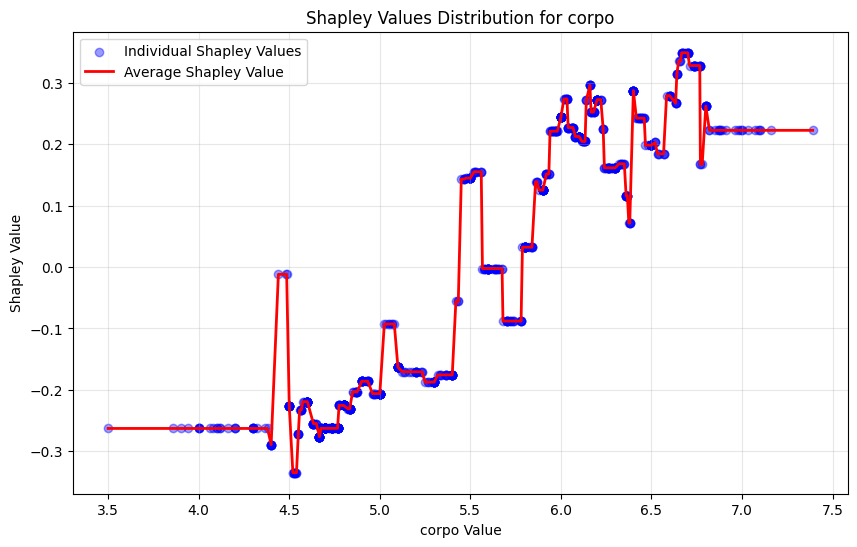

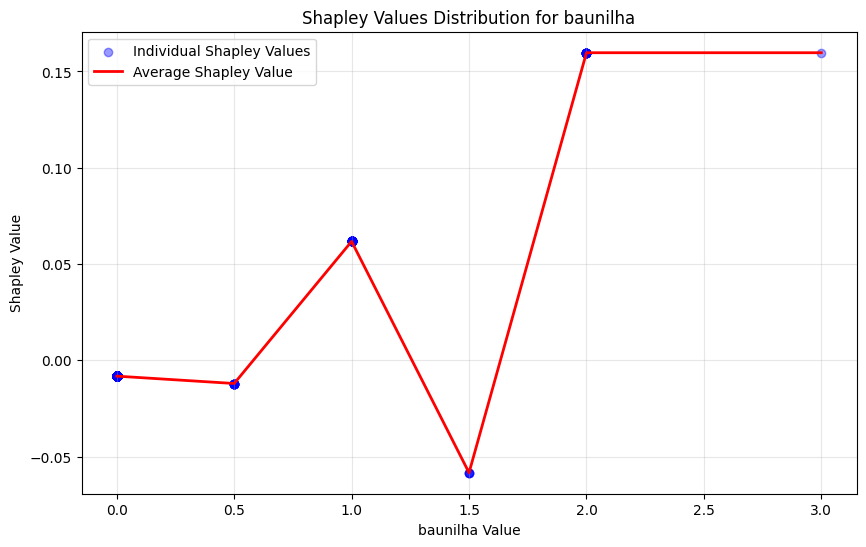

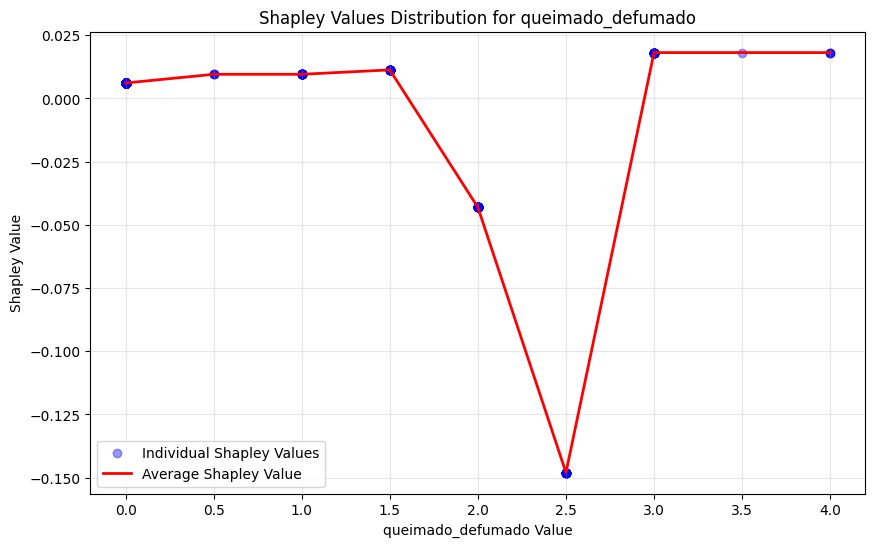

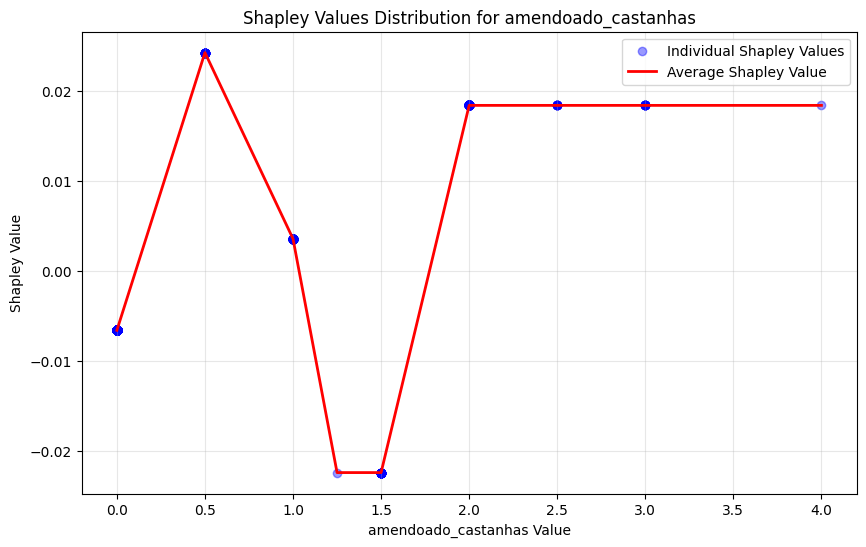

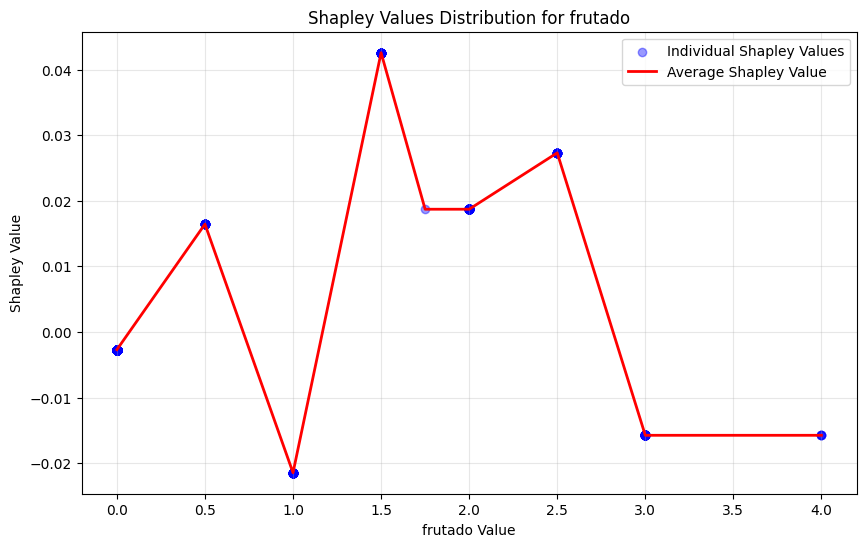

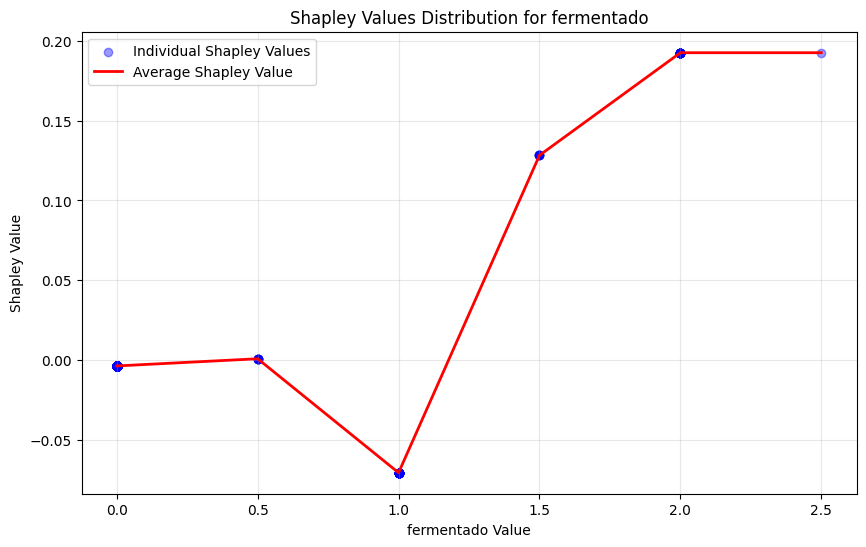

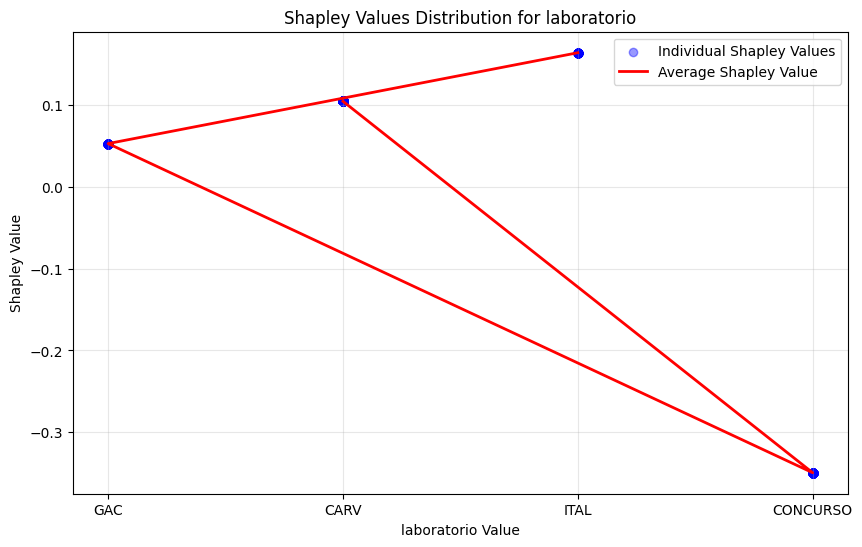

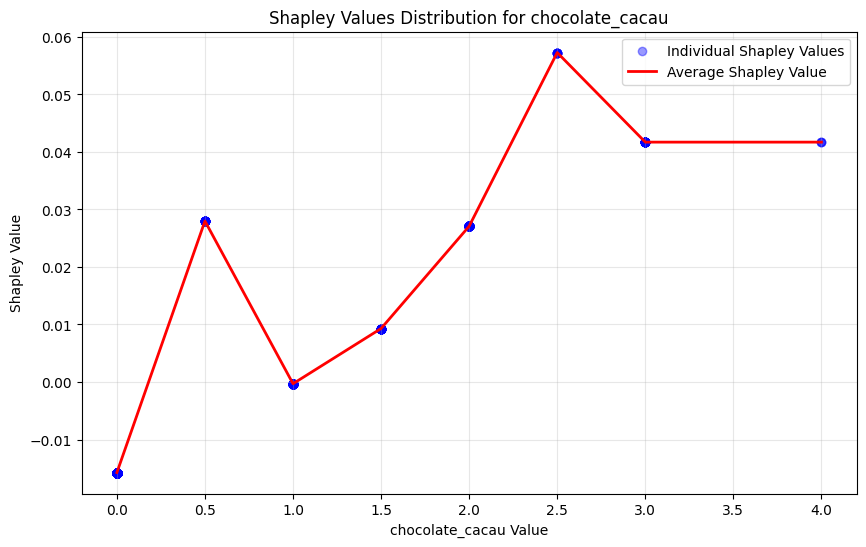

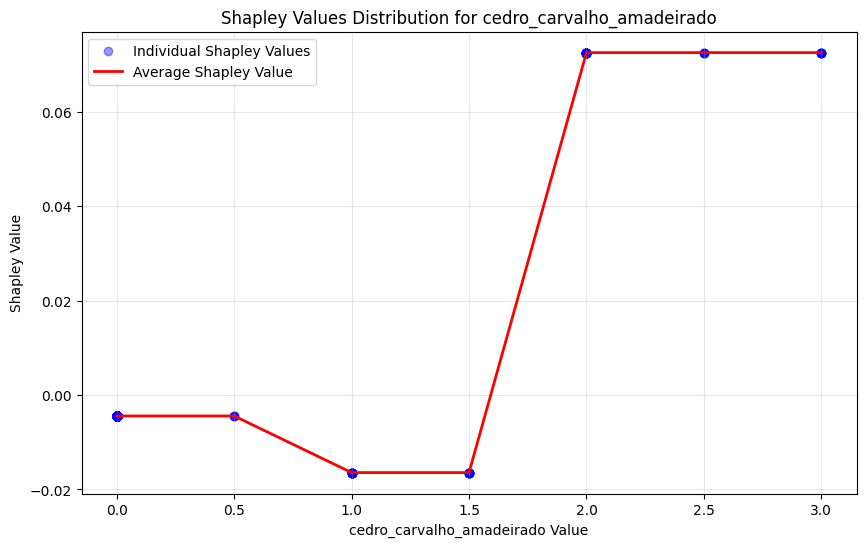

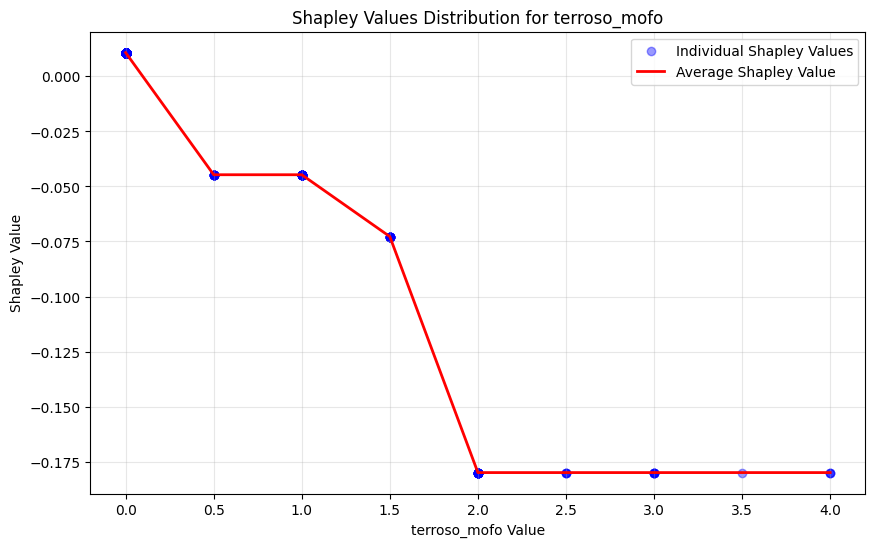

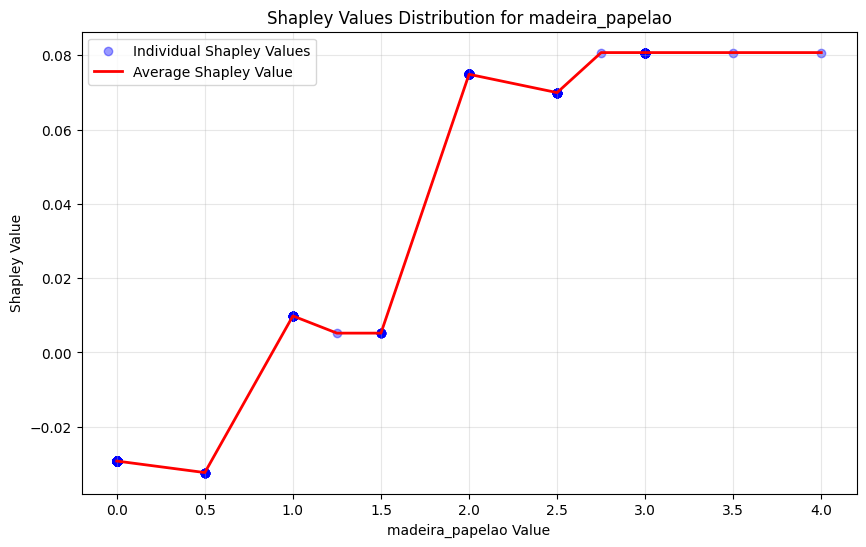

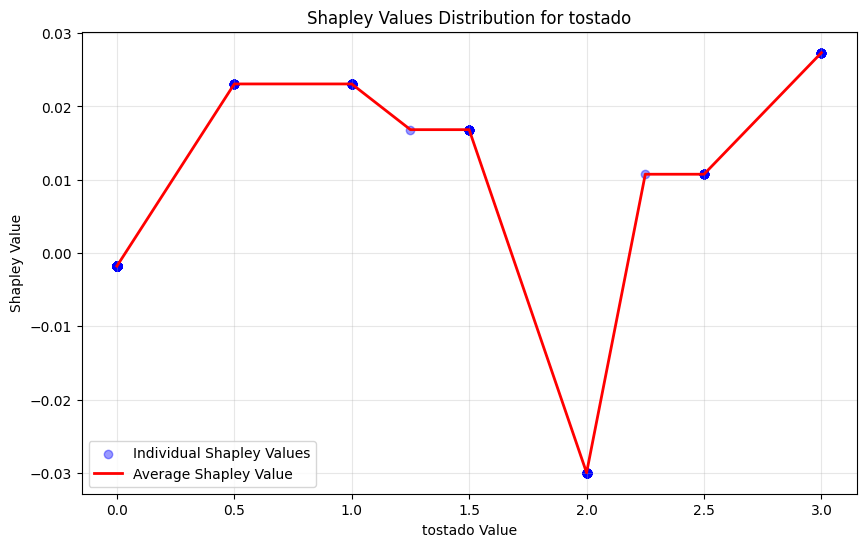

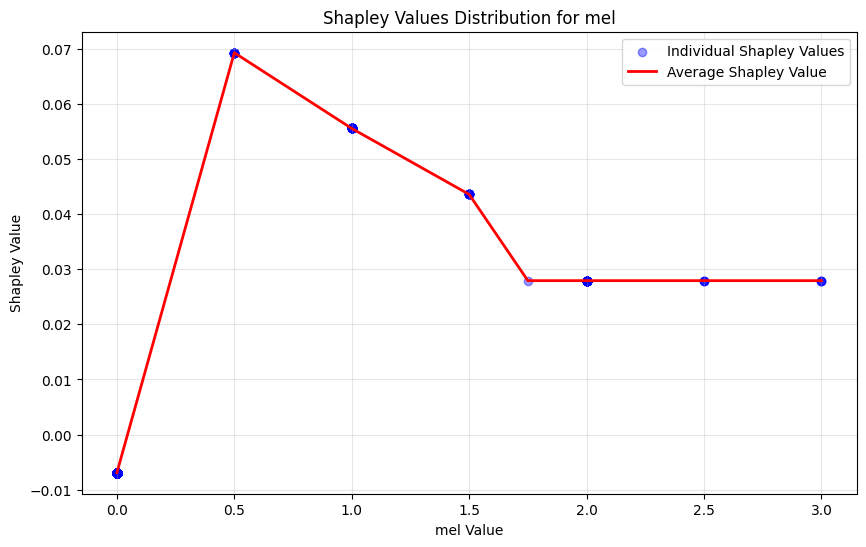

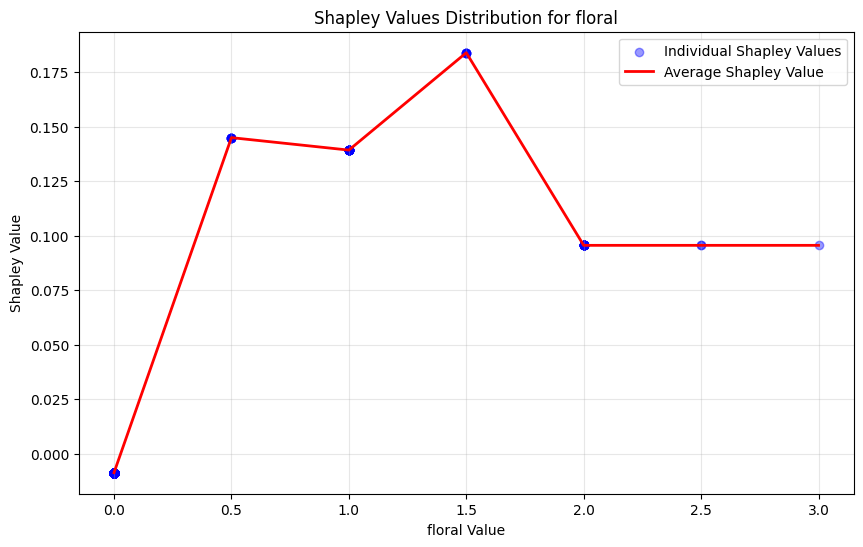

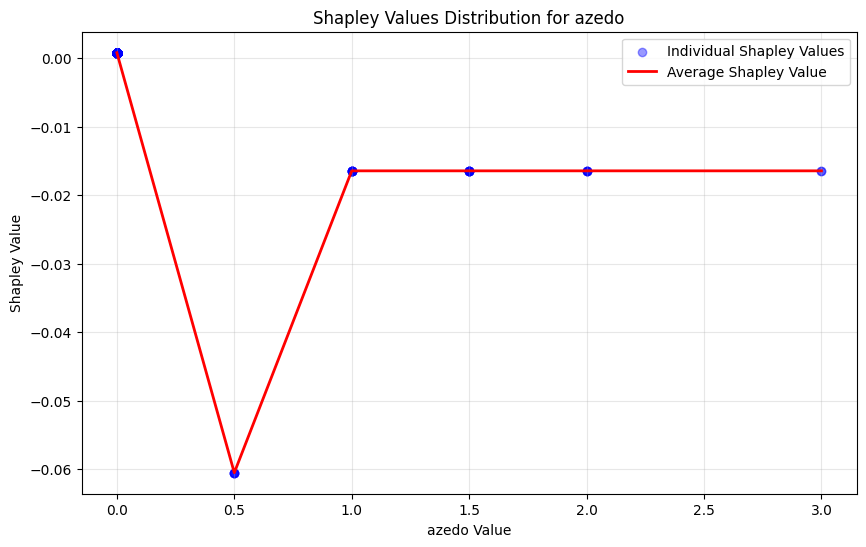

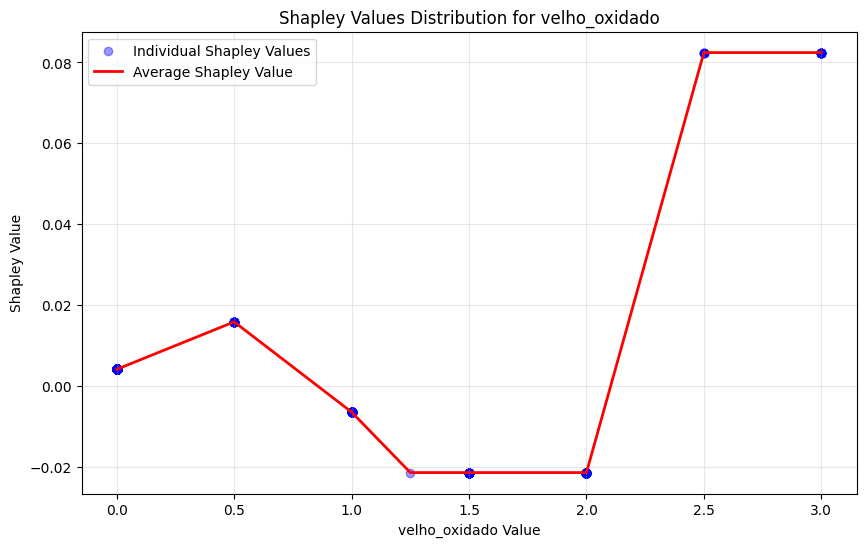

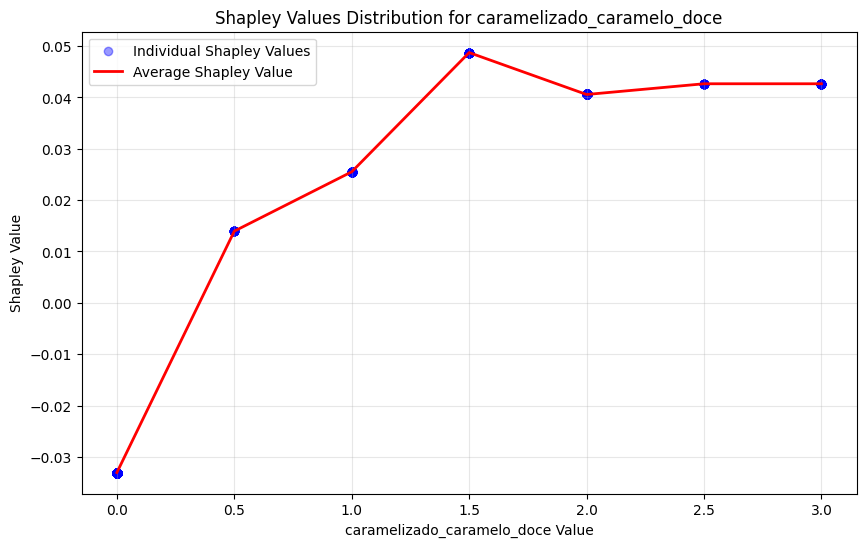

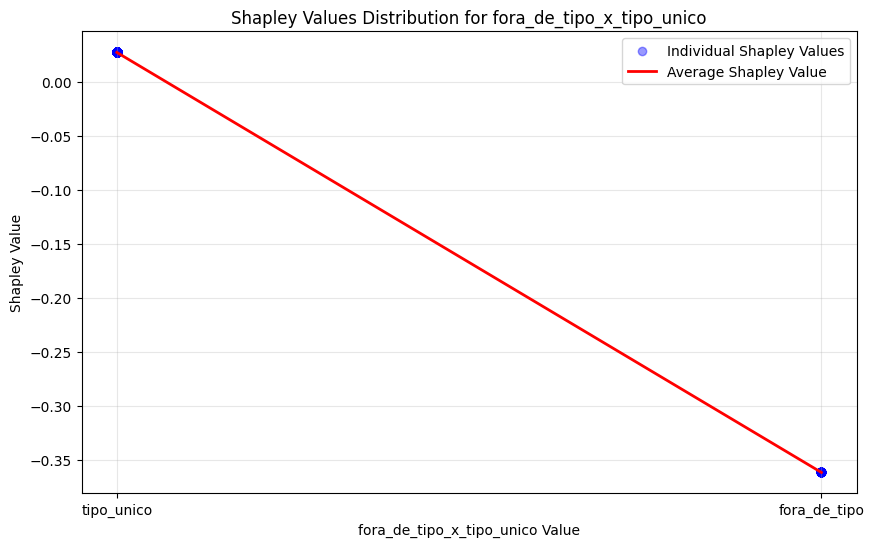

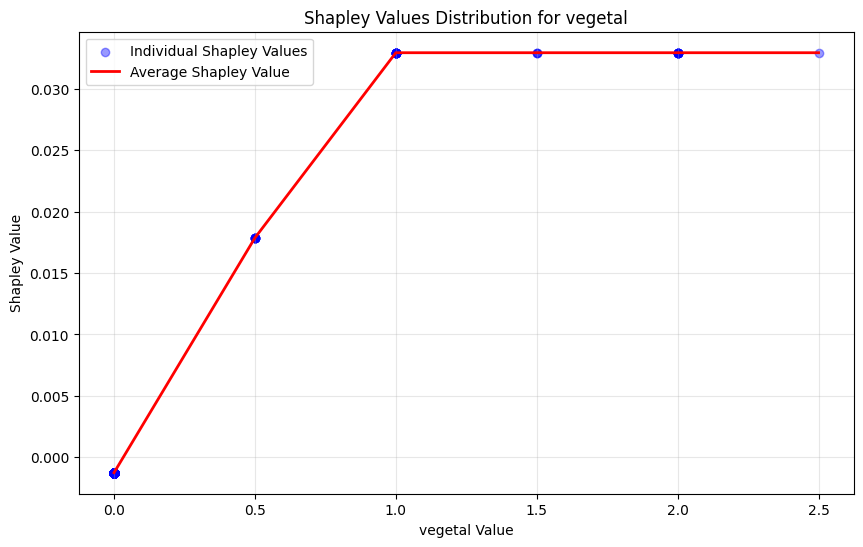

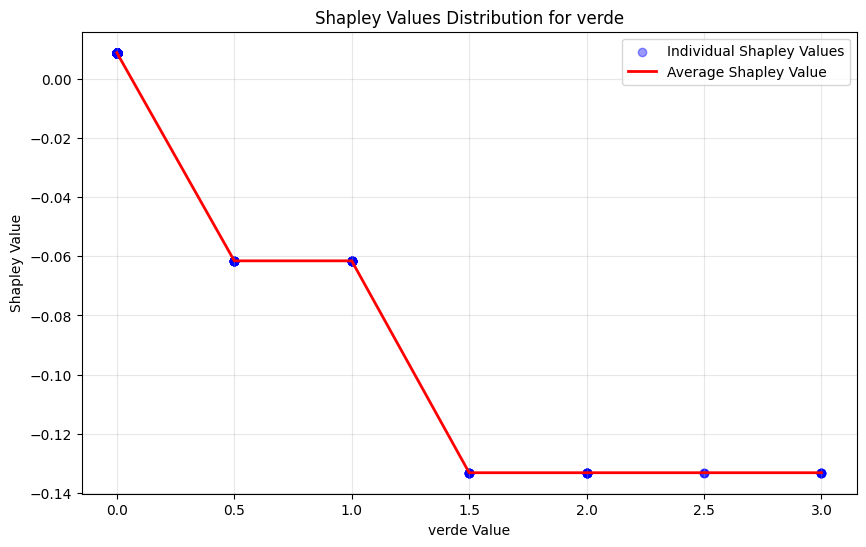

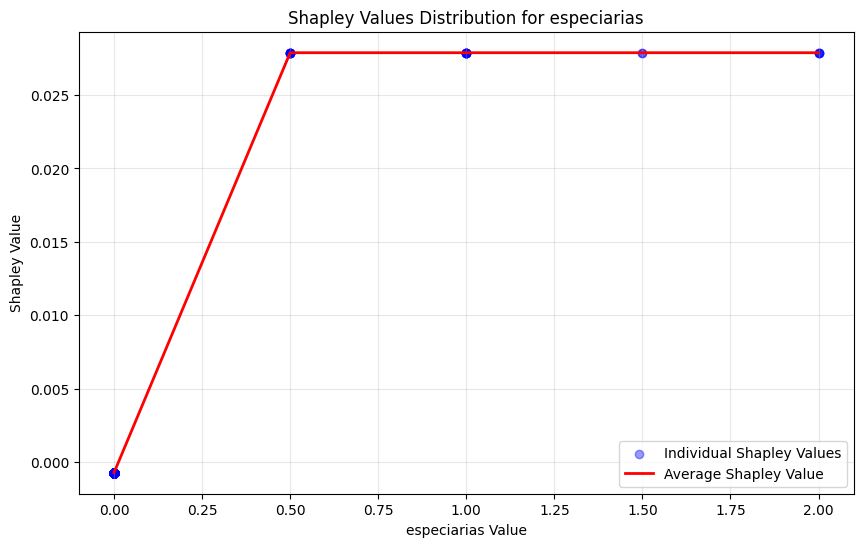

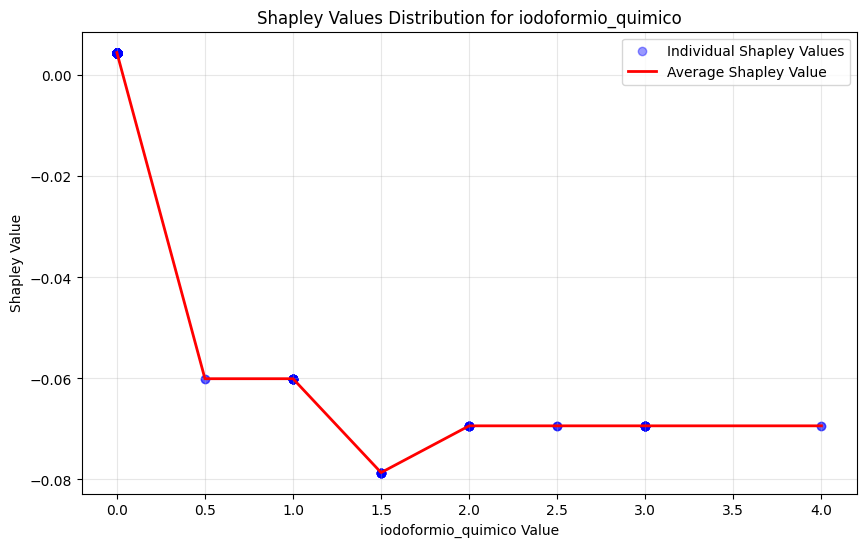

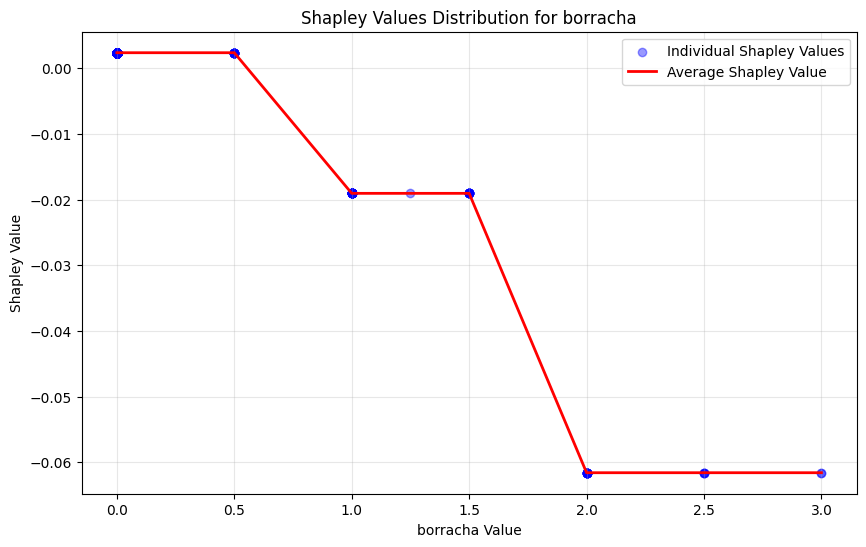

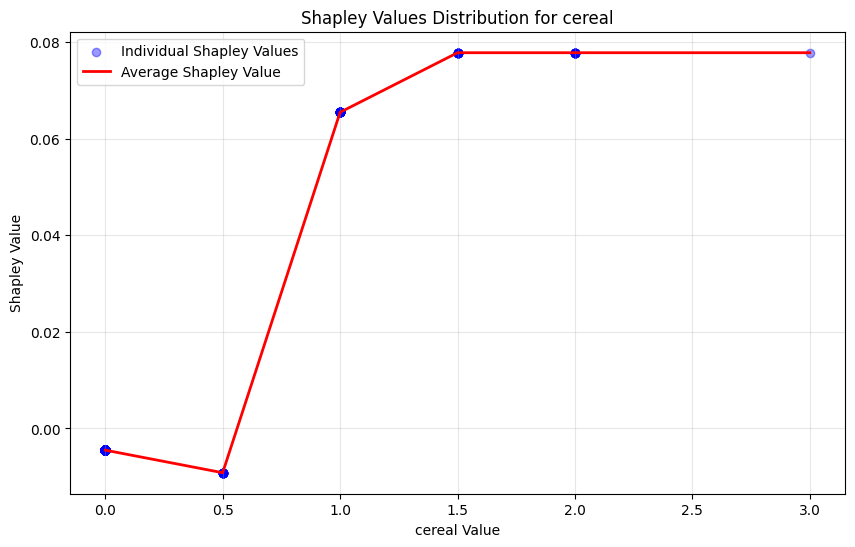

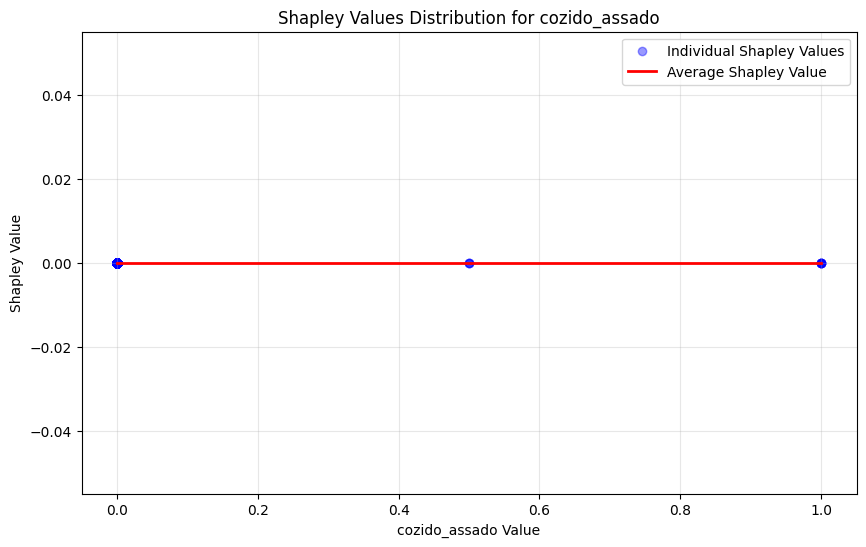

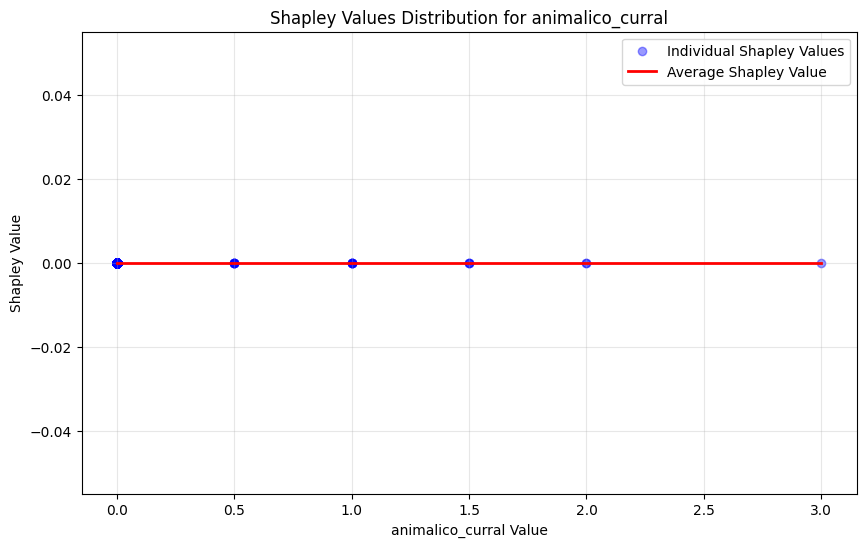

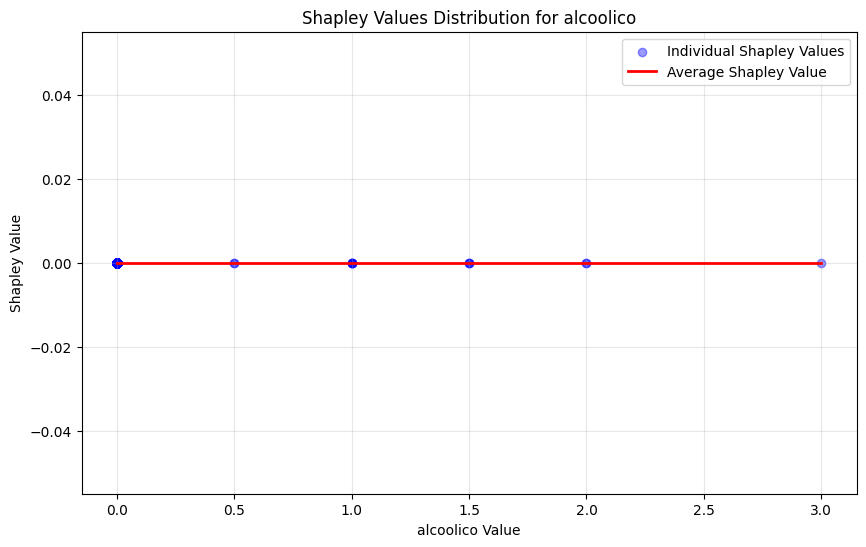

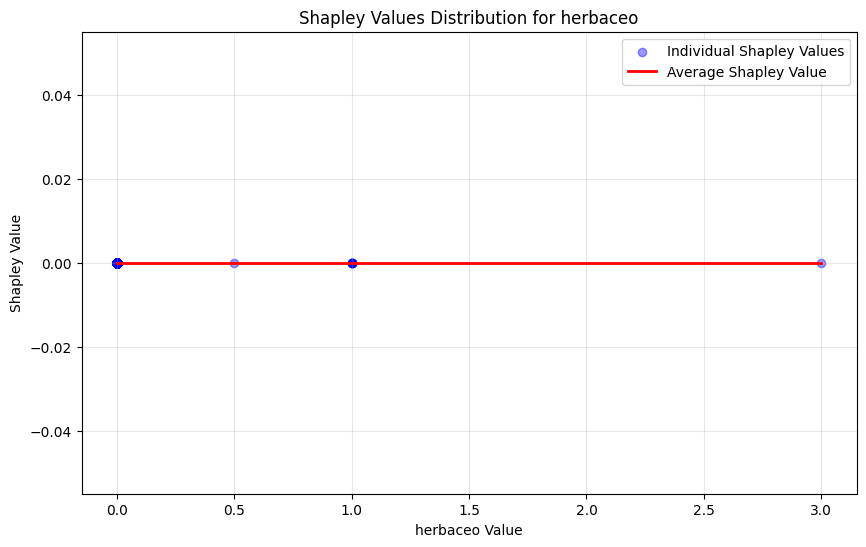

In [18]:
from func import plot_shapley_values

for name in main_imp.index.values:
    plot_shapley_values(shap_df,trn_data ,name)


# <a id='toc7_'></a>[Interaction analysis](#toc0_)

In [19]:
est_data = trn_data.copy()
for cat_var in categorical_features:
    est_data[cat_var] = est_data[cat_var].cat.codes


In [20]:
from shap.utils import approximate_interactions
import shap

exp = TreeExplainer(int_mdl)
shap_interaction_values = exp.shap_interaction_values(est_data)
shap_vals = exp.shap_values(trn_data)


shap_df = pd.DataFrame(shap_vals, columns=trn_data.columns)
int_order = {}

for col in trn_data.columns:
   int_order[col] = approximate_interactions(index=col, shap_values=shap_vals, X=trn_data, feature_names=trn_data.columns)



## <a id='toc7_1_'></a>[Main interactions](#toc0_)

In [21]:
tbl = dict()
for col in int_imp.index.values:

    int_vars = [trn_data.columns[int_order[col][i]] for i in range(3)]
    tbl[col]=int_vars

tbl = pd.DataFrame(tbl).transpose()
tbl.index.name = "Feature"
tbl.columns = ["Top 1 interaction", "Top 2 interaction", "Top 3 interaction"]
tbl

Top 1 interaction  \
Feature                                                  
odor_do_po                  caramelizado_caramelo_doce   
intensidade                                     docura   
amargor                                    intensidade   
corpo                                          amargor   
acidez_intensidade                              docura   
adstringencia                                  tostado   
acidez_qualidade                           intensidade   
chocolate_cacau                             odor_do_po   
velho_oxidado                              laboratorio   
queimado_defumado                     acidez_qualidade   
docura                                         tostado   
tostado                                        amargor   
madeira_papelao                      queimado_defumado   
laboratorio                              velho_oxidado   
caramelizado_caramelo_doce             chocolate_cacau   
frutado                            amendoado_castanhas   
terroso_mofo                                    docura   
amendoado_castanhas                  queimado_defumado   
borracha                                 velho_oxidado   
fora_de_tipo_x_tipo_unico                velho_oxidado   
cereal                                      odor_do_po   
mel                                amendoado_castanhas   
verde                                queimado_defumado   
cedro_carvalho_amadeirado                   odor_do_po   
iodoformio_quimico                     madeira_papelao   
baunilha                                       frutado   
fermentado                            acidez_qualidade   
floral                                 chocolate_cacau   
especiarias                            madeira_papelao   
vegetal                             acidez_intensidade   
azedo                                          amargor   
animalico_curral                           laboratorio   
cozido_assado                              laboratorio   
alcoolico                                  laboratorio   
herbaceo                                   laboratorio   

                                     Top 2 interaction  \
Feature                                                  
odor_do_po                          acidez_intensidade   
intensidade                           acidez_qualidade   
amargor                                    laboratorio   
corpo                                      laboratorio   
acidez_intensidade                         laboratorio   
adstringencia                              laboratorio   
acidez_qualidade                            odor_do_po   
chocolate_cacau                            laboratorio   
velho_oxidado                               odor_do_po   
queimado_defumado                   acidez_intensidade   
docura                                     intensidade   
tostado                                  adstringencia   
madeira_papelao                                amargor   
laboratorio                          queimado_defumado   
caramelizado_caramelo_doce                     tostado   
frutado                             acidez_intensidade   
terroso_mofo                           madeira_papelao   
amendoado_castanhas                 acidez_intensidade   
borracha                             queimado_defumado   
fora_de_tipo_x_tipo_unico             acidez_qualidade   
cereal                      caramelizado_caramelo_doce   
mel                                    chocolate_cacau   
verde                                       odor_do_po   
cedro_carvalho_amadeirado              madeira_papelao   
iodoformio_quimico                       velho_oxidado   
baunilha                            acidez_intensidade   
fermentado                                      docura   
floral                                          docura   
especiarias                                      corpo   
vegetal                               acidez_qualidade   
azedo                             

## <a id='toc7_2_'></a>[Interaction plots](#toc0_)

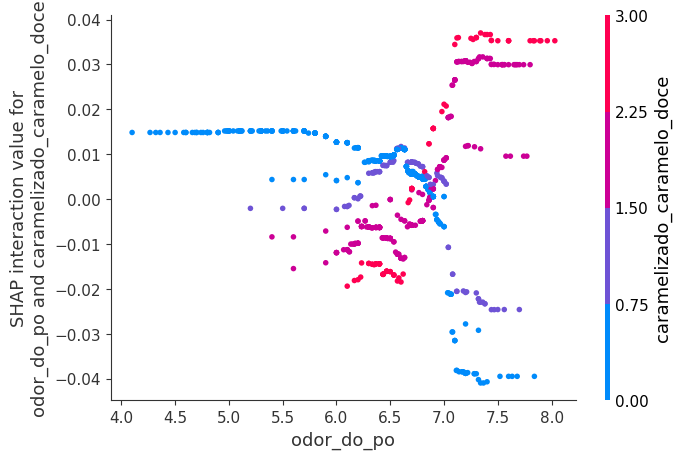

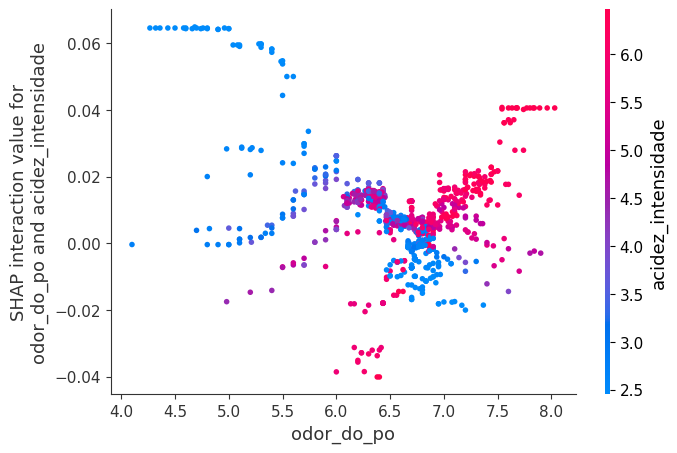

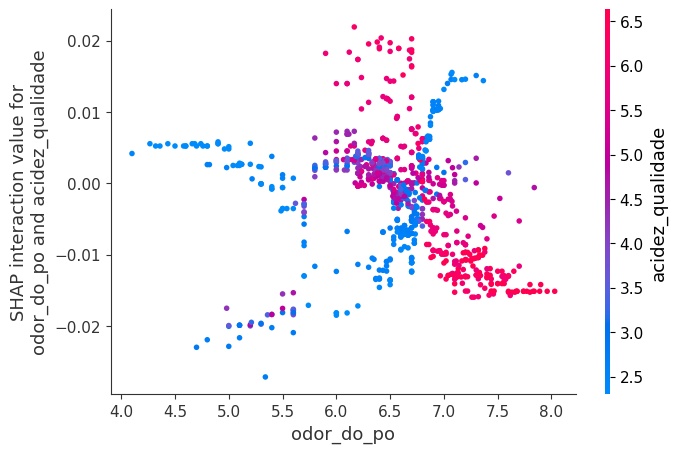

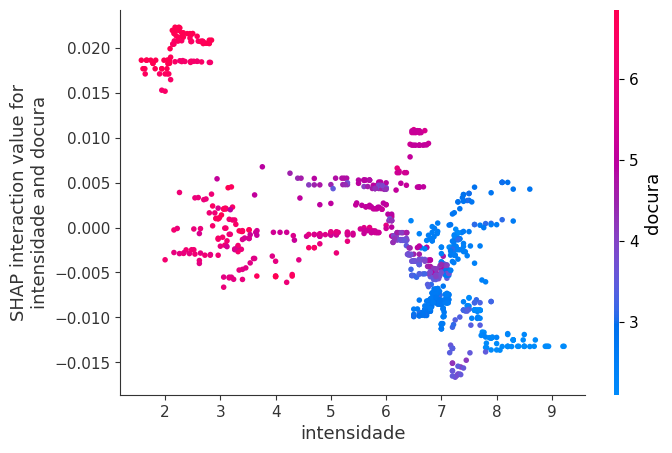

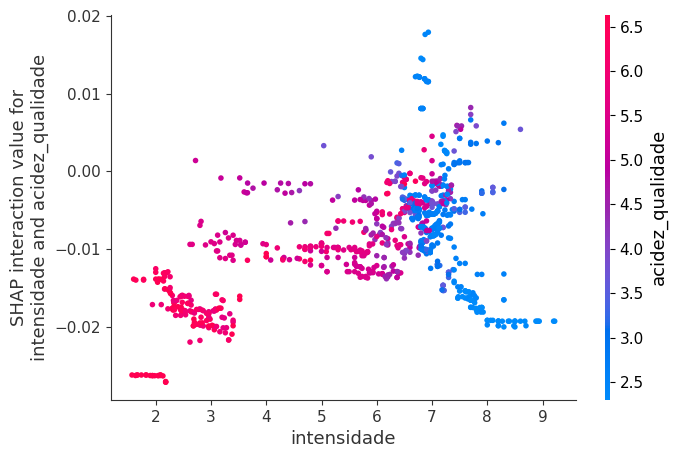

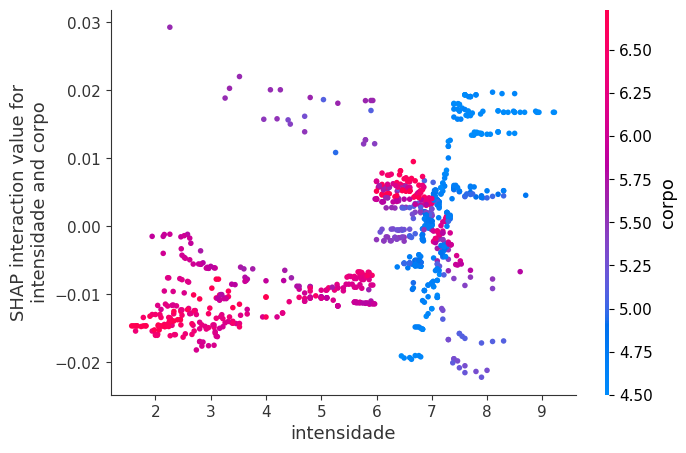

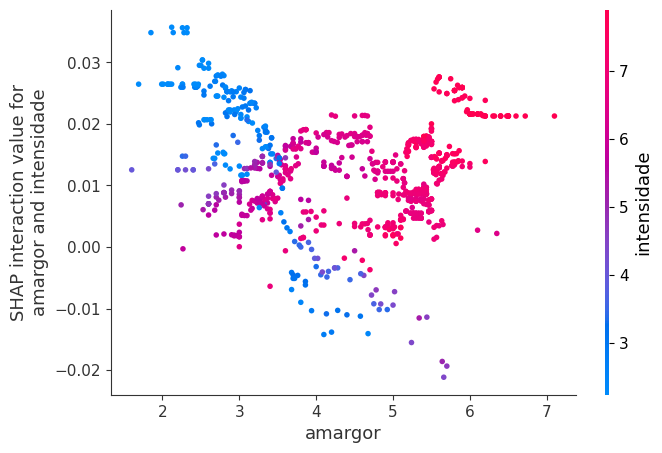

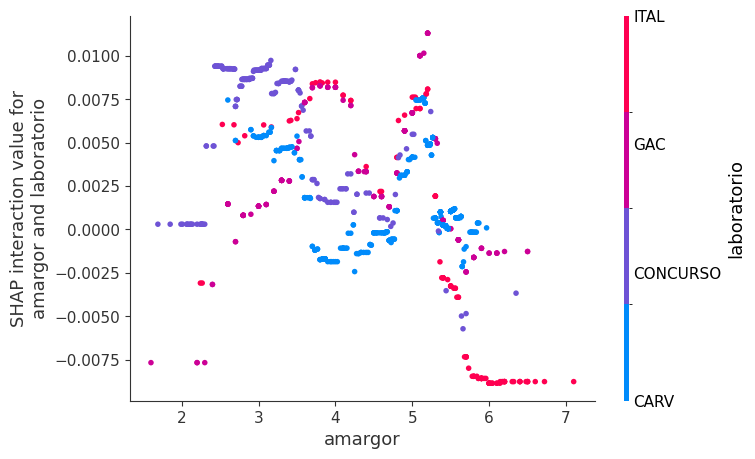

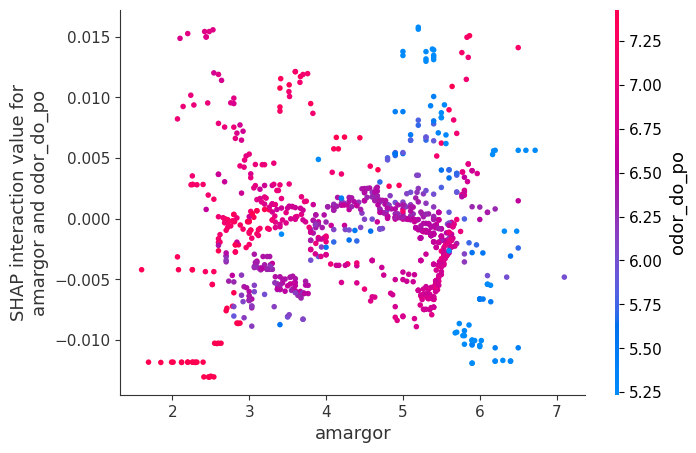

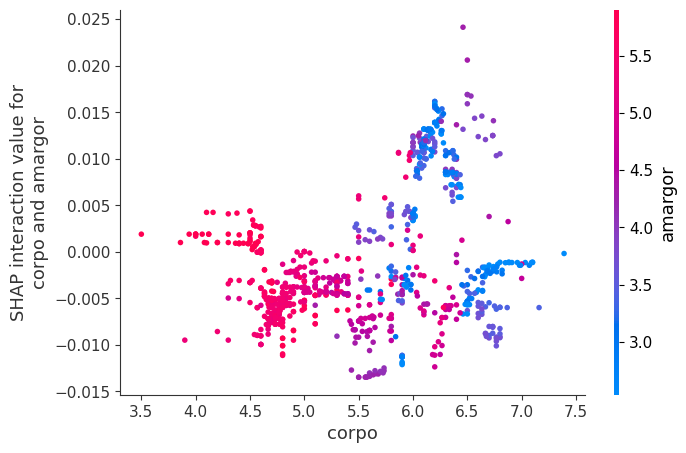

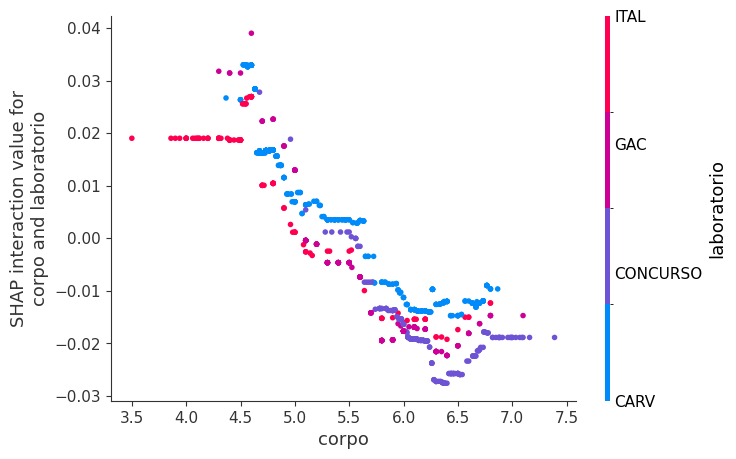

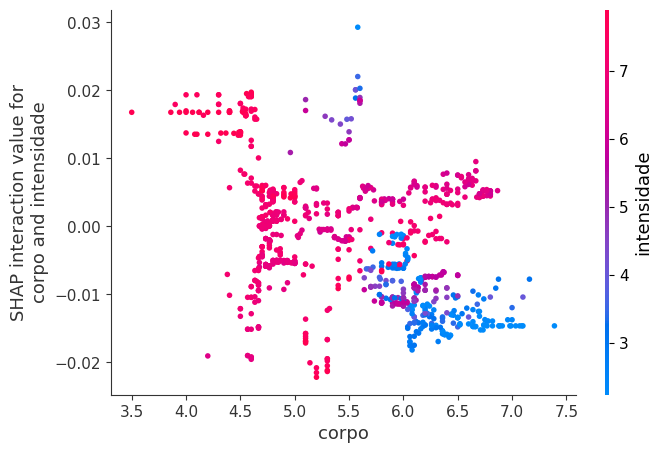

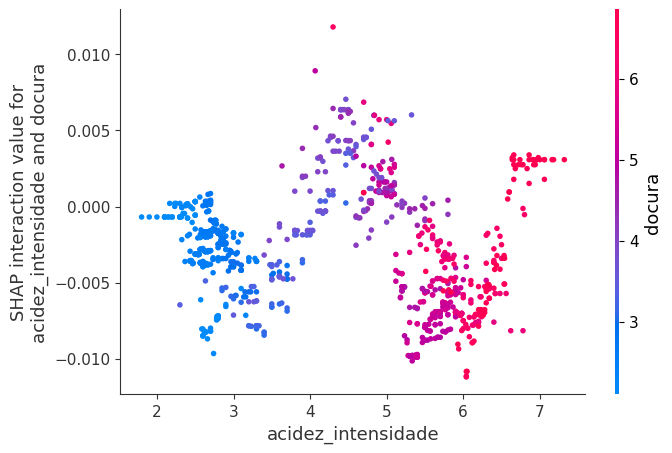

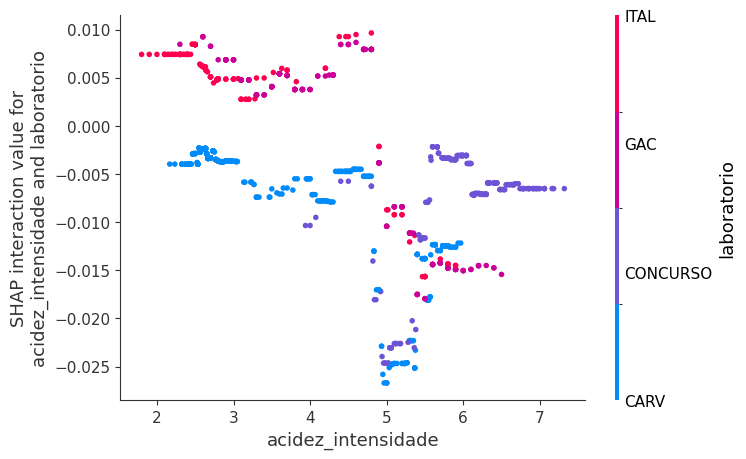

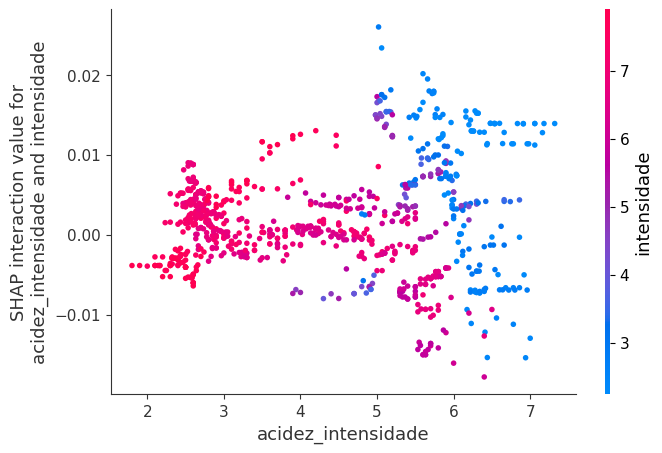

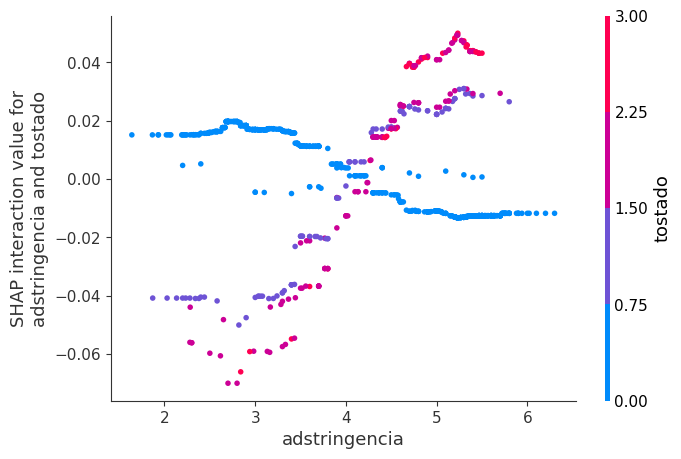

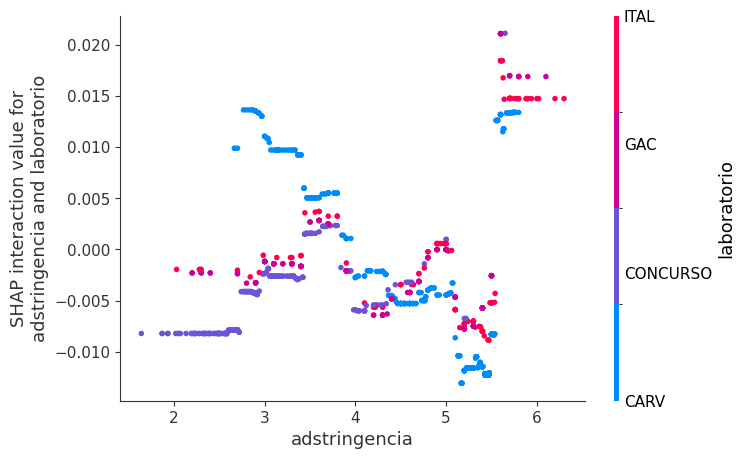

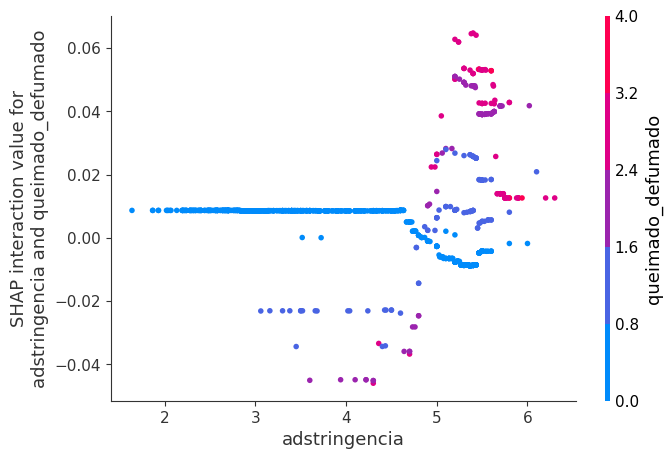

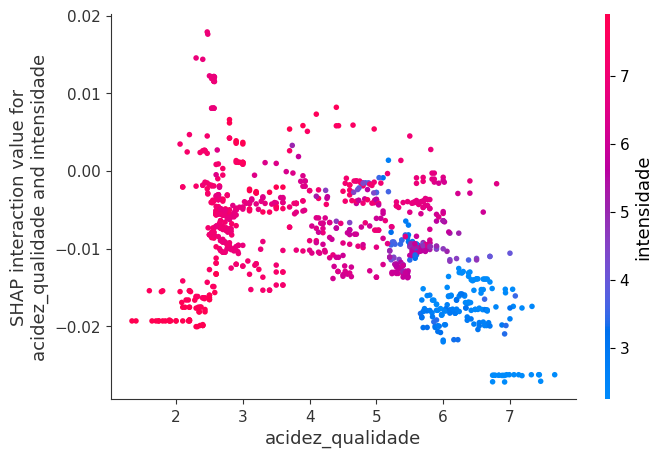

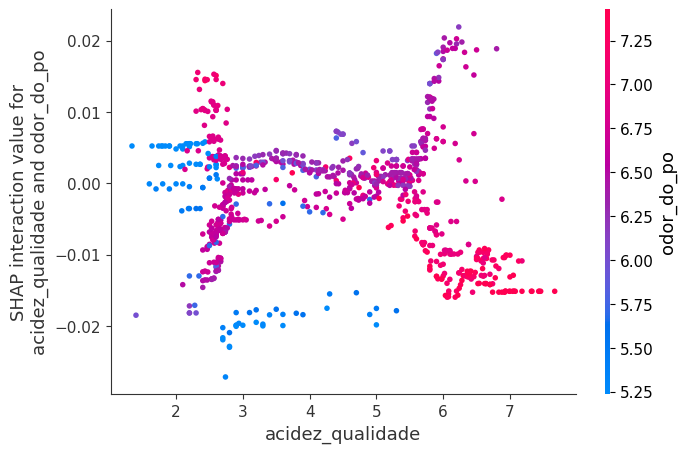

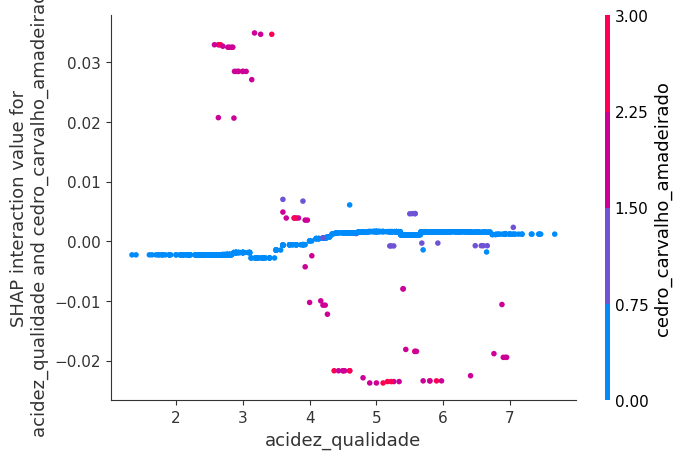

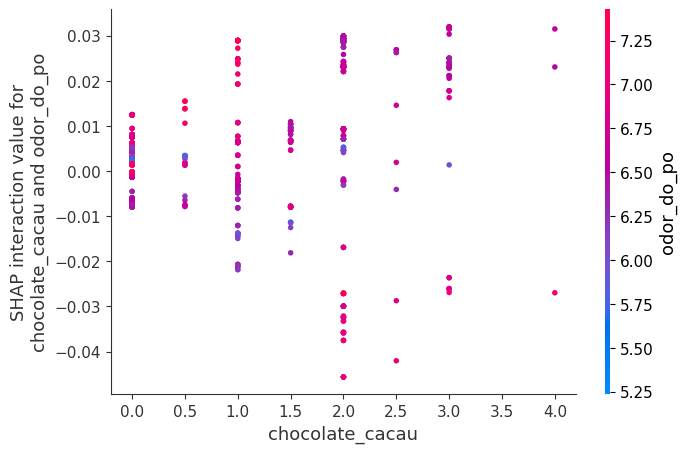

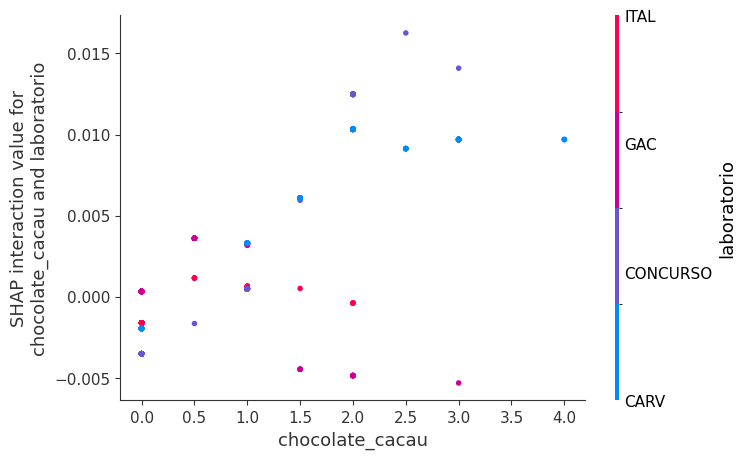

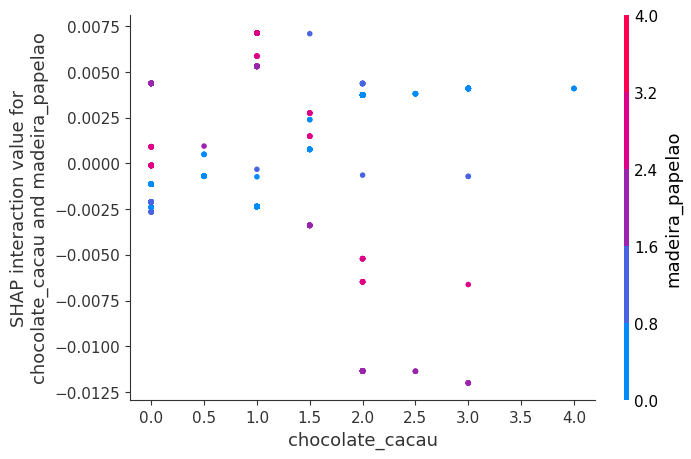

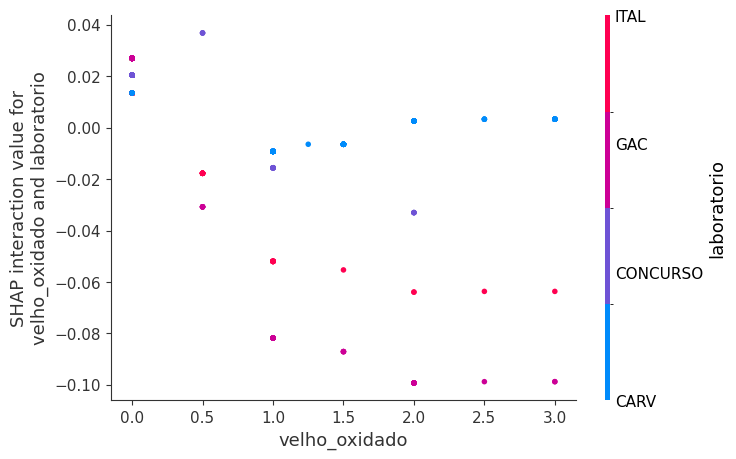

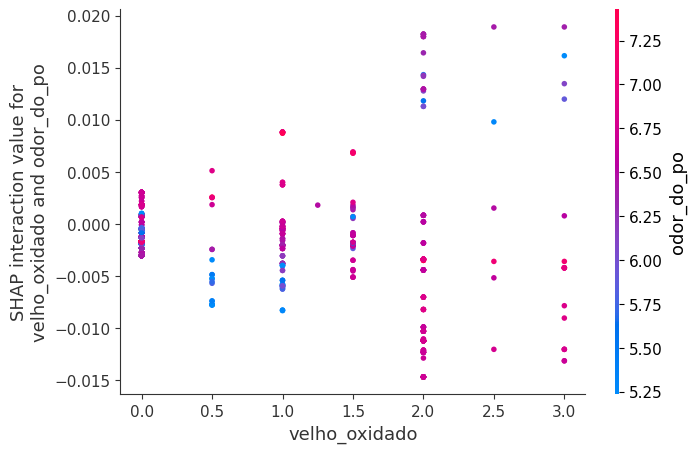

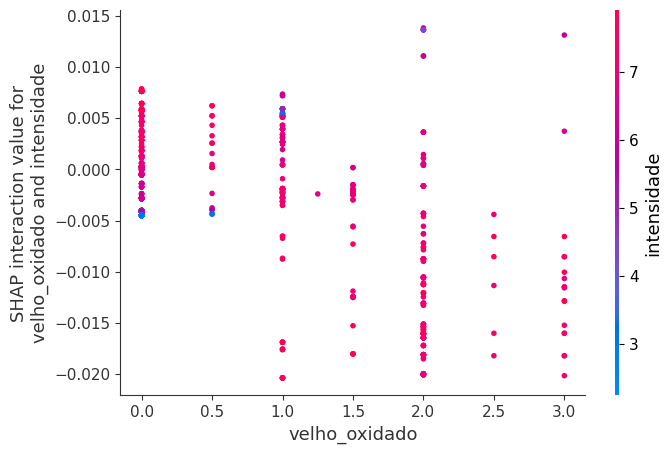

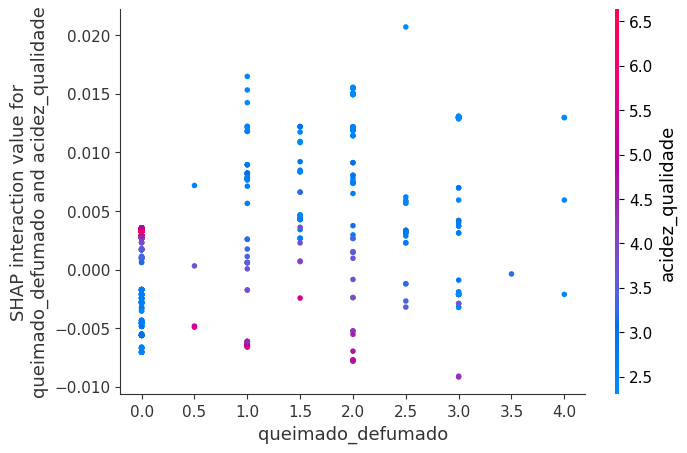

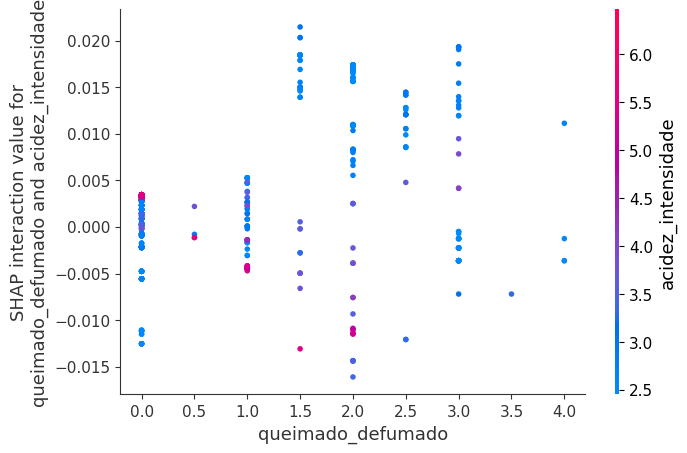

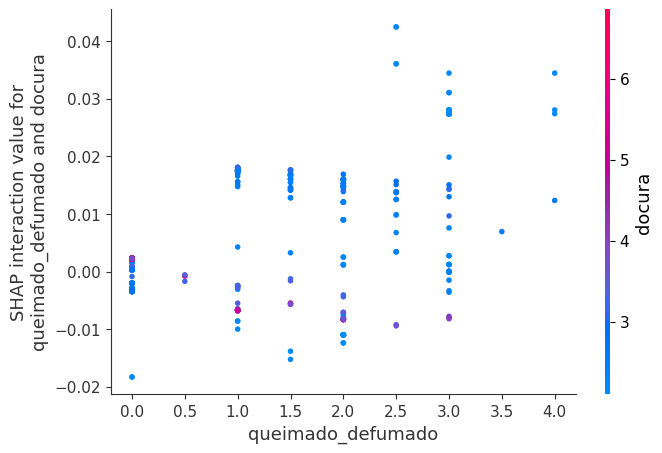

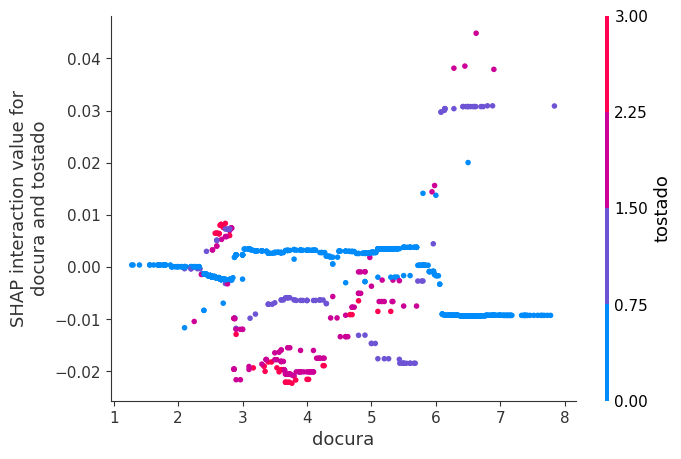

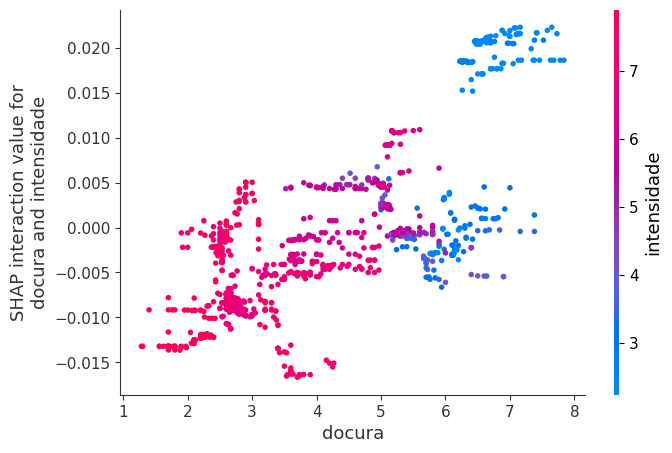

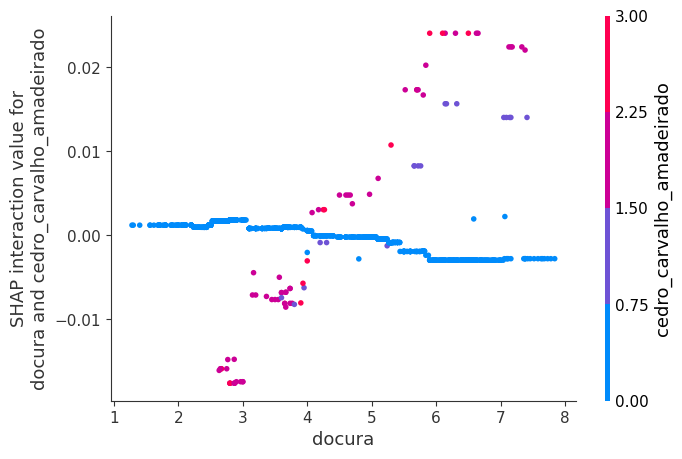

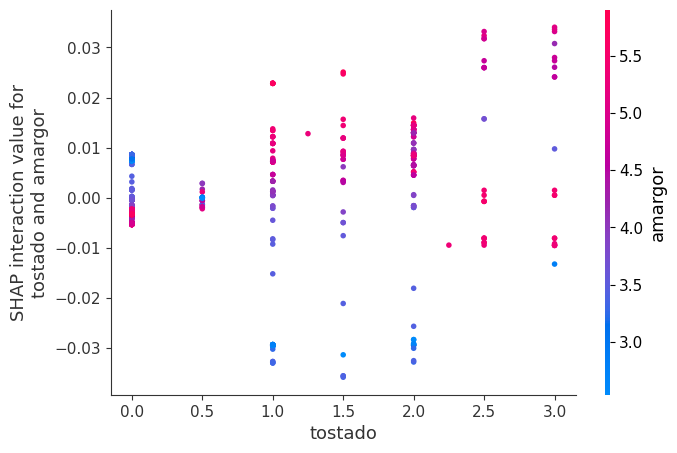

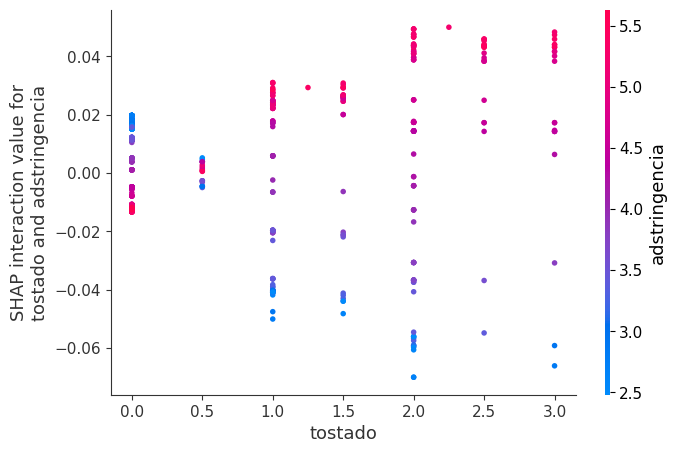

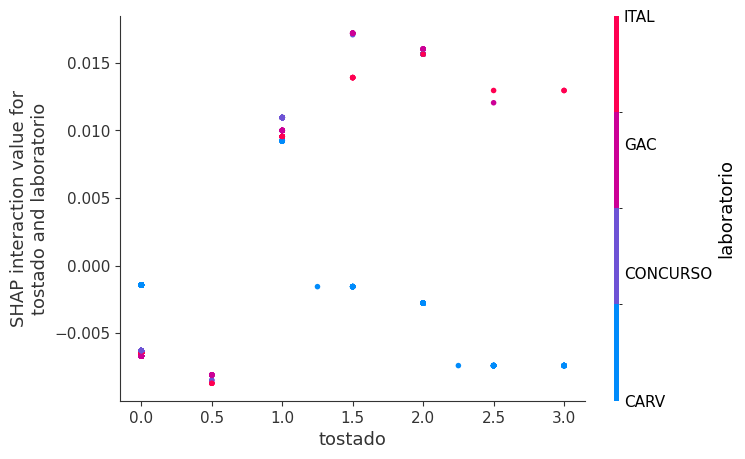

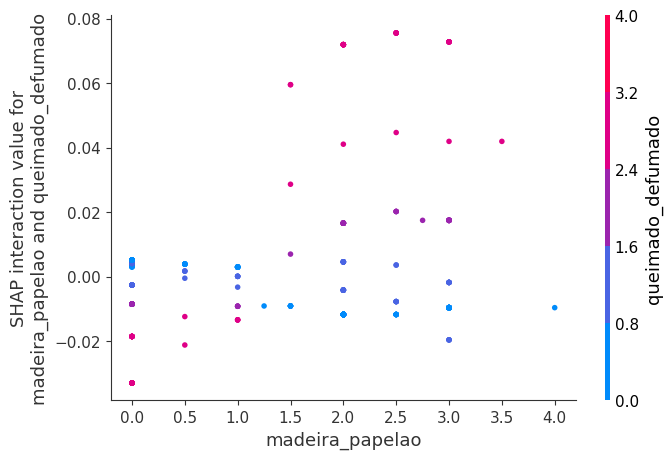

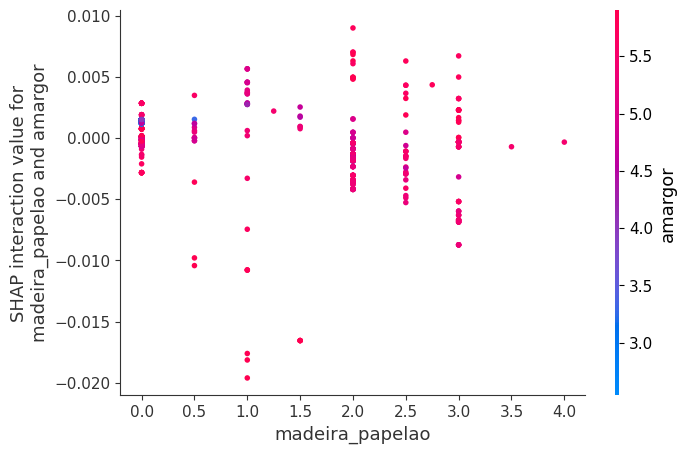

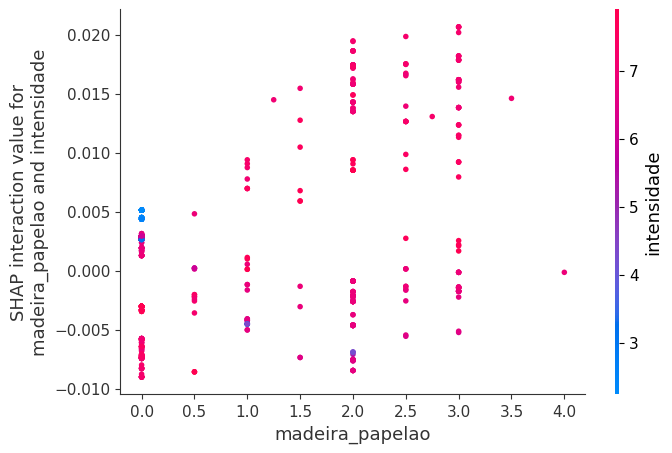

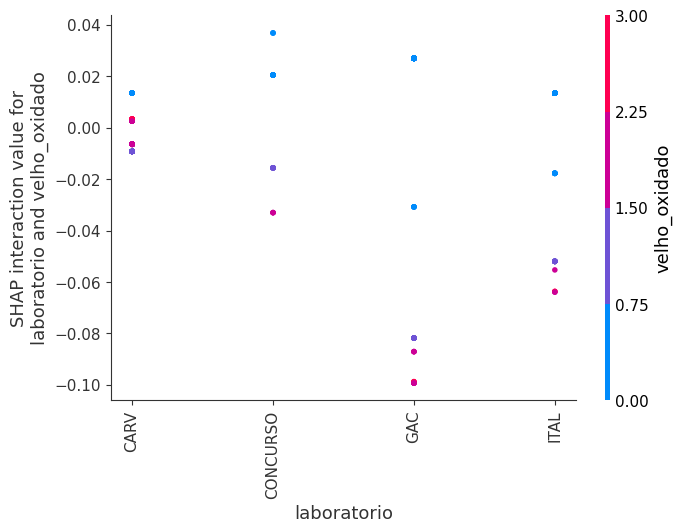

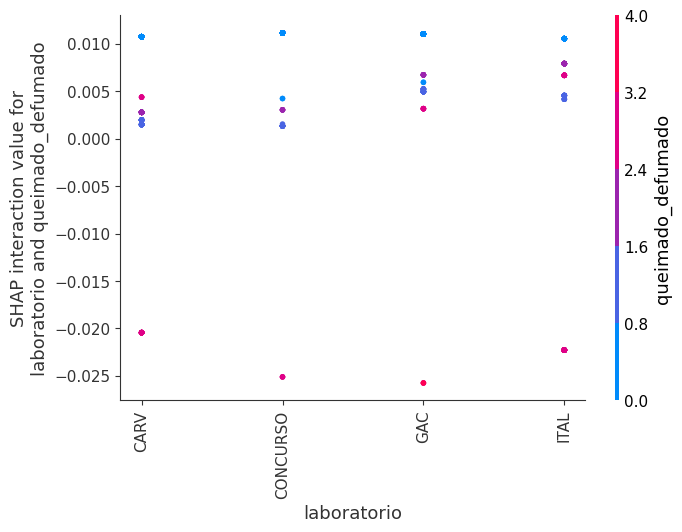

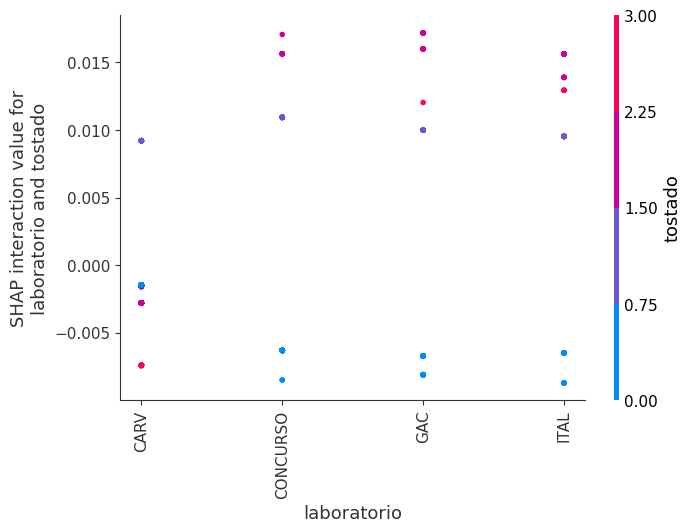

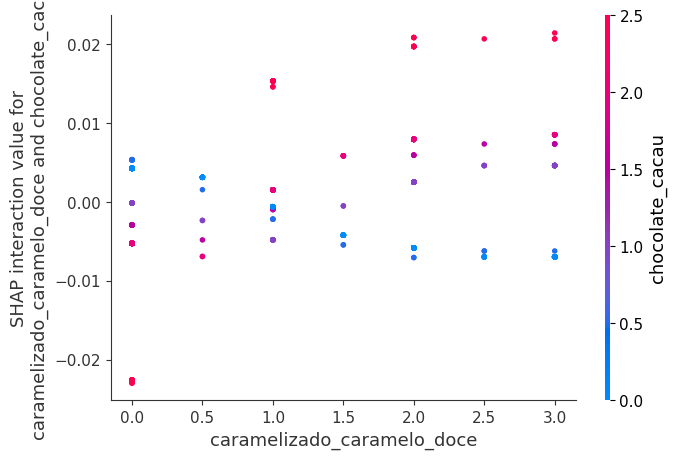

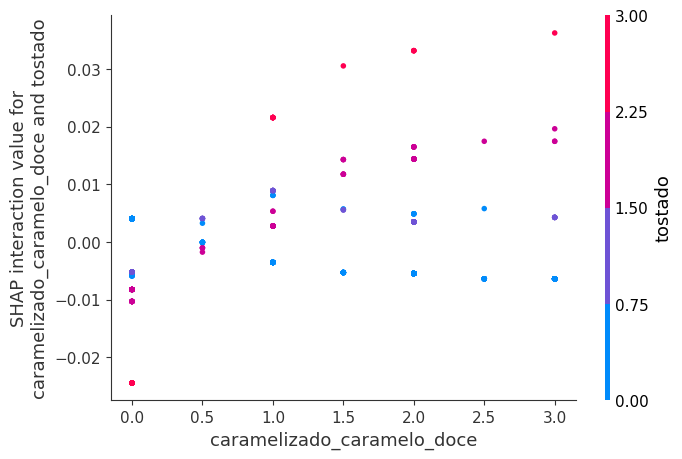

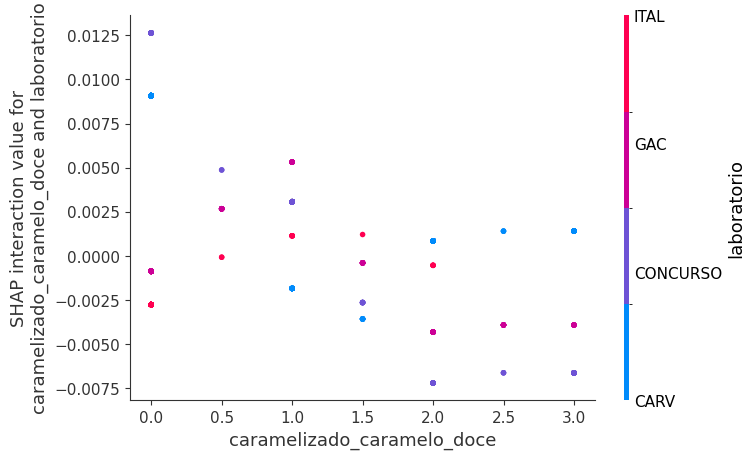

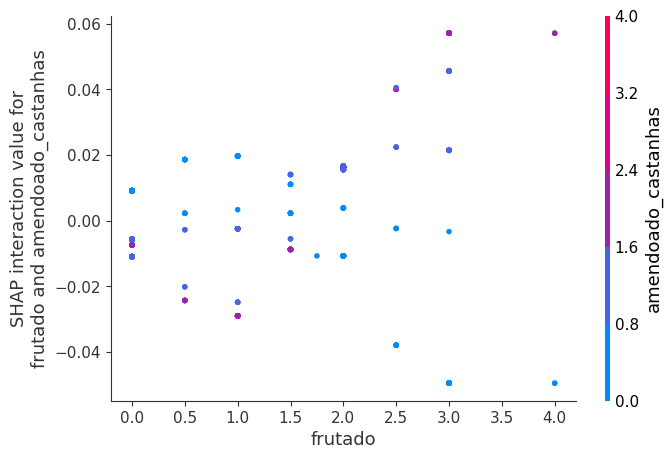

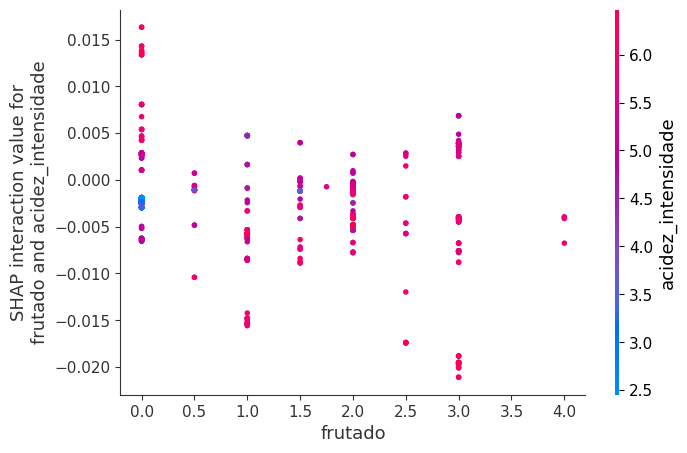

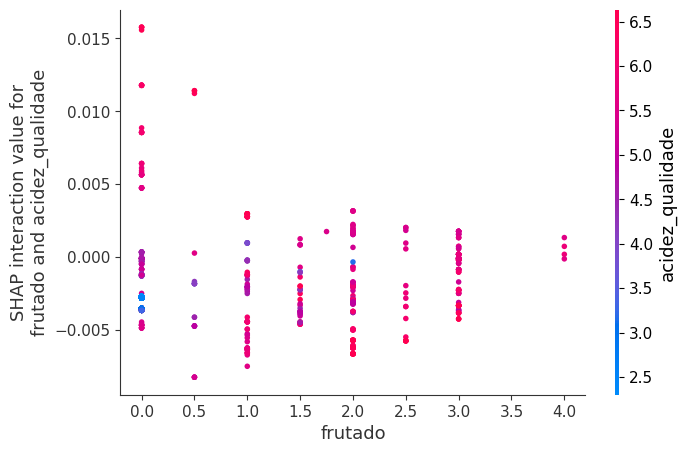

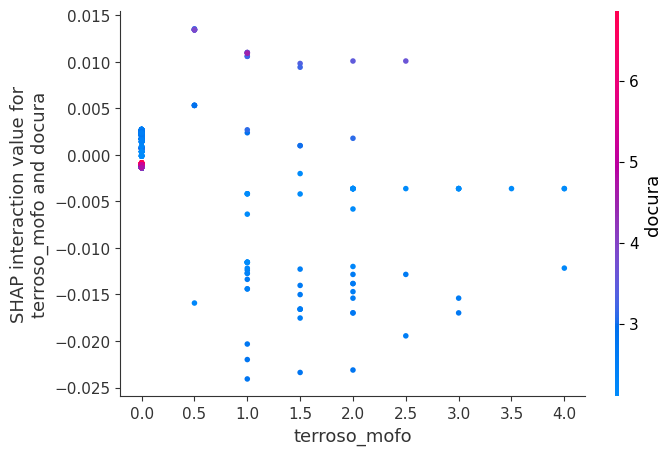

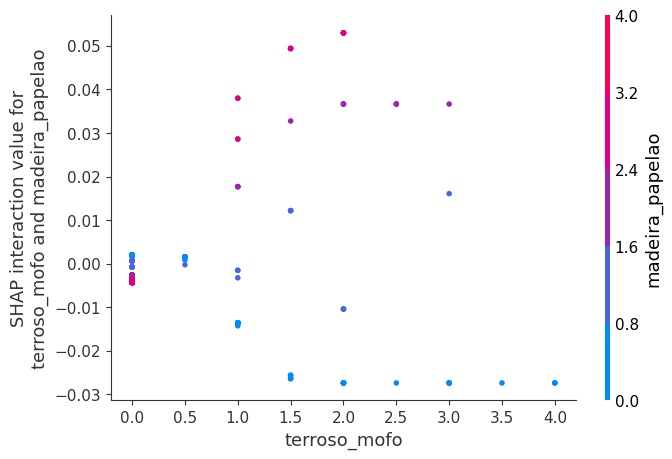

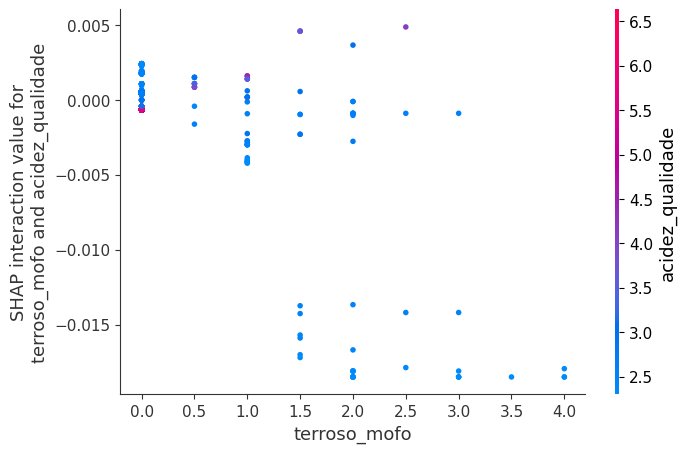

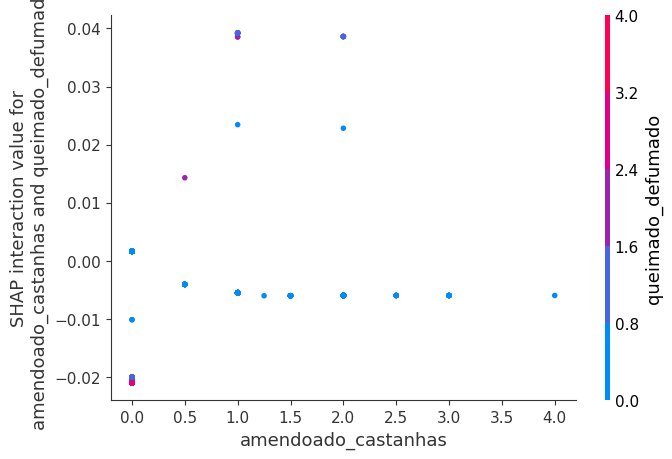

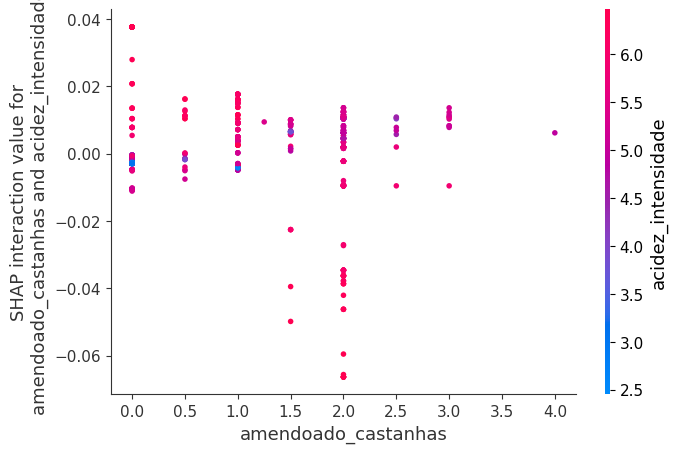

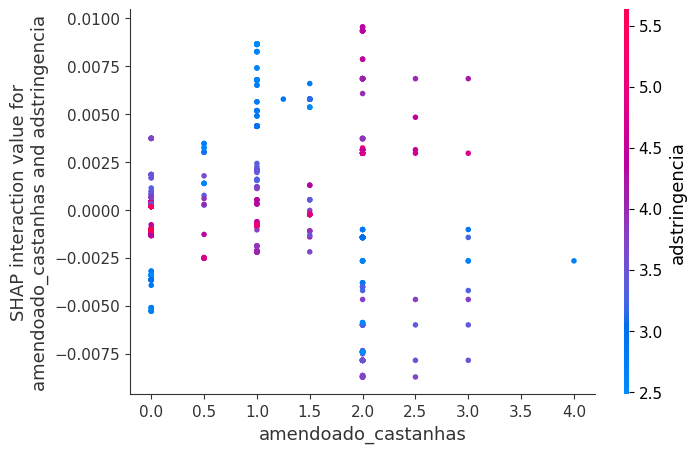

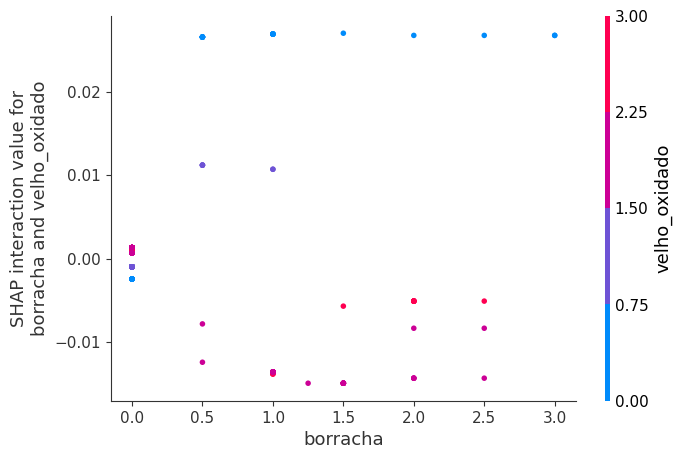

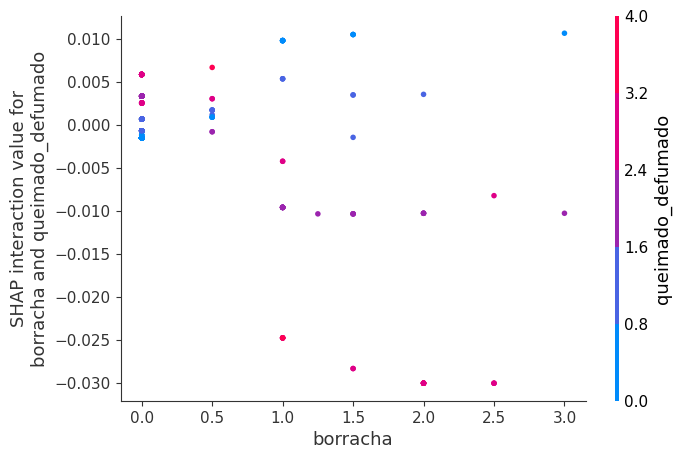

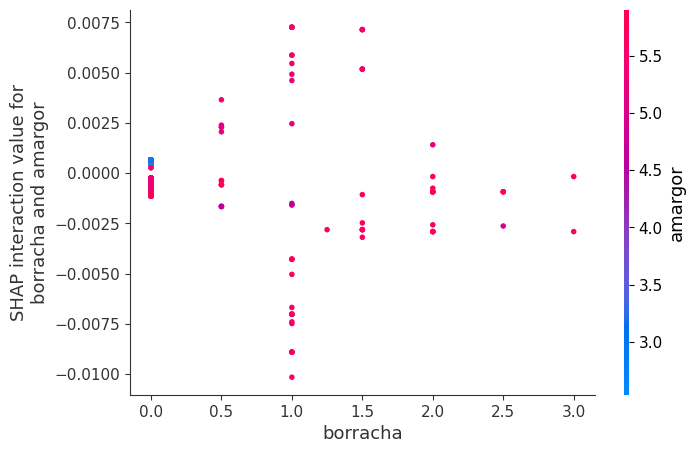

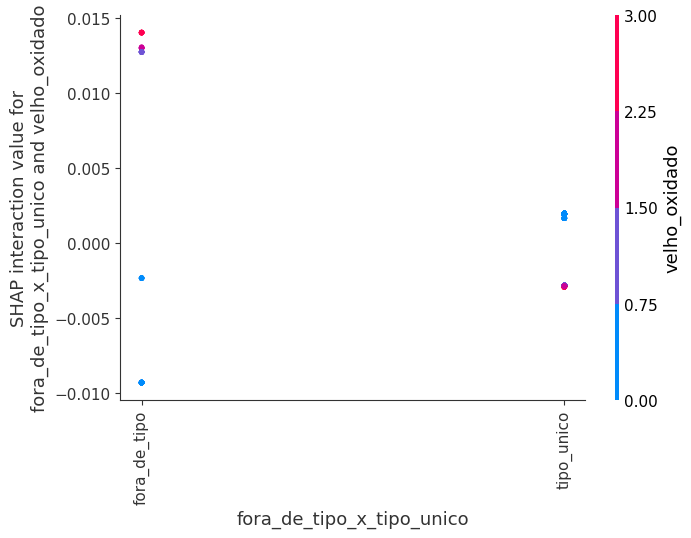

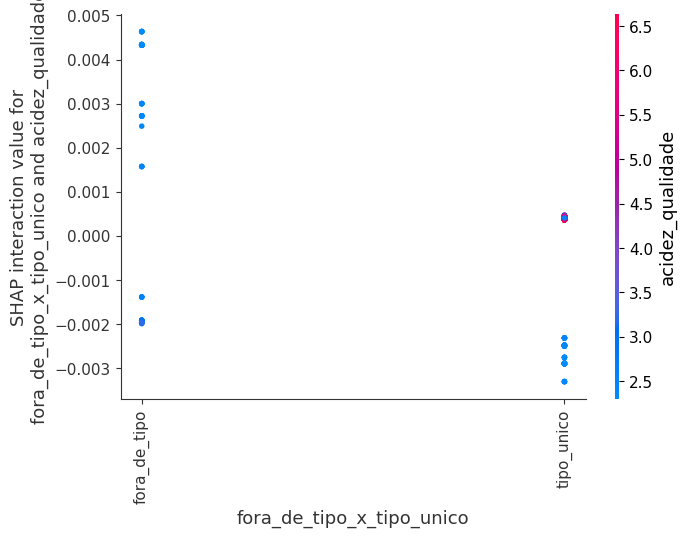

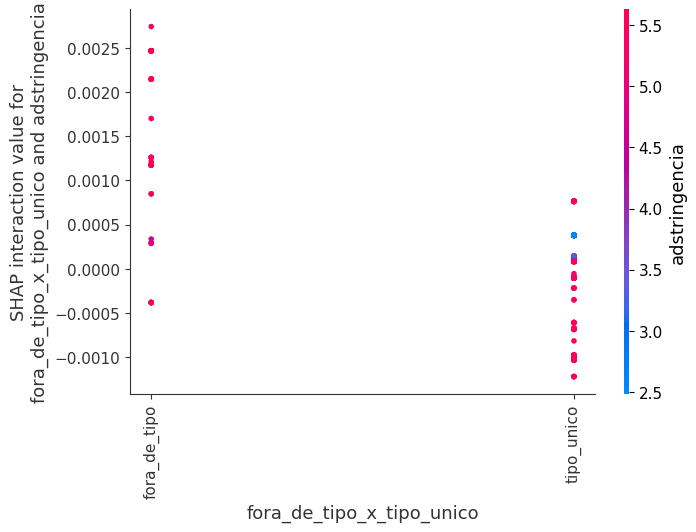

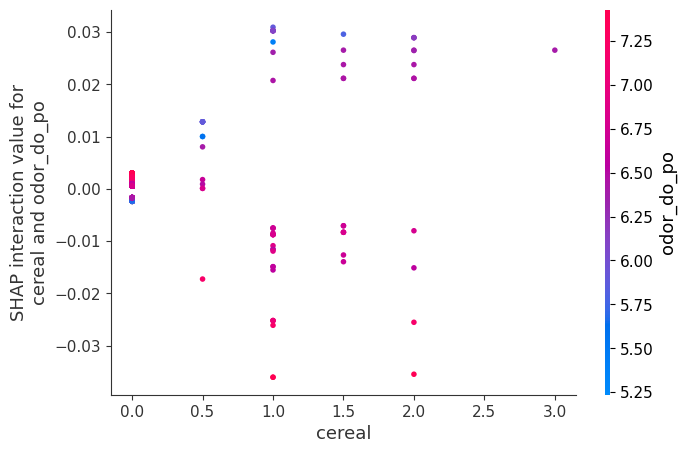

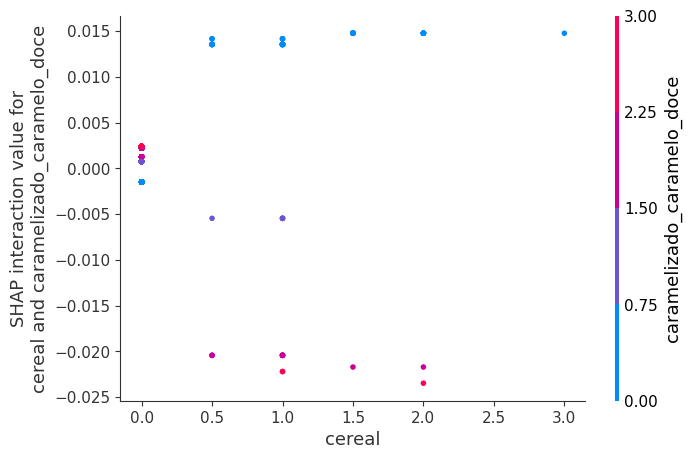

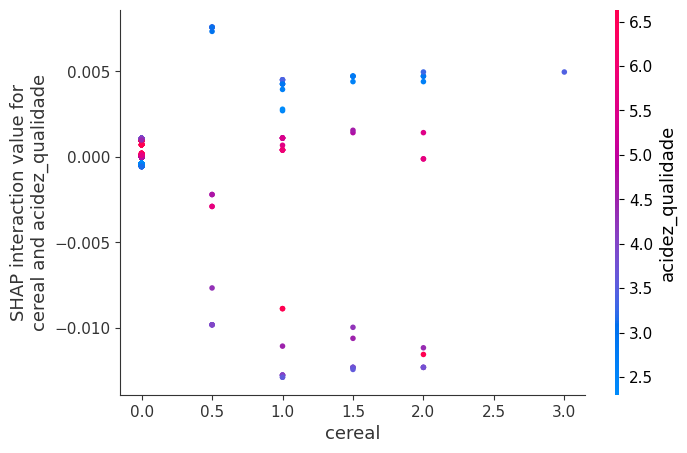

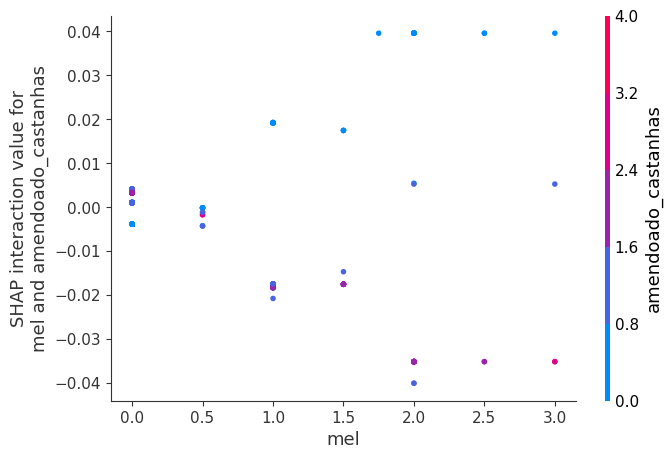

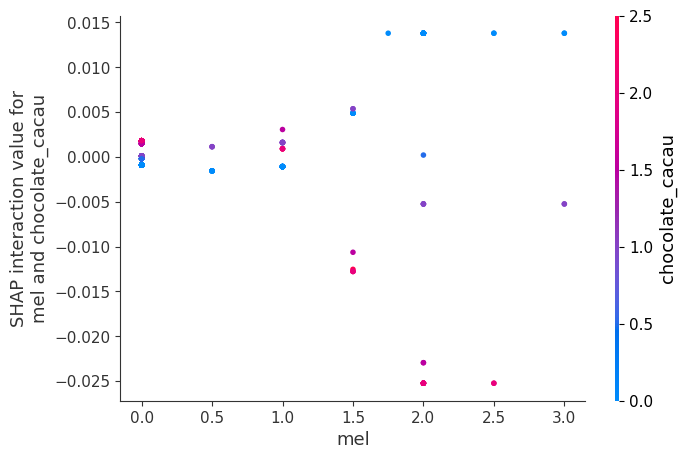

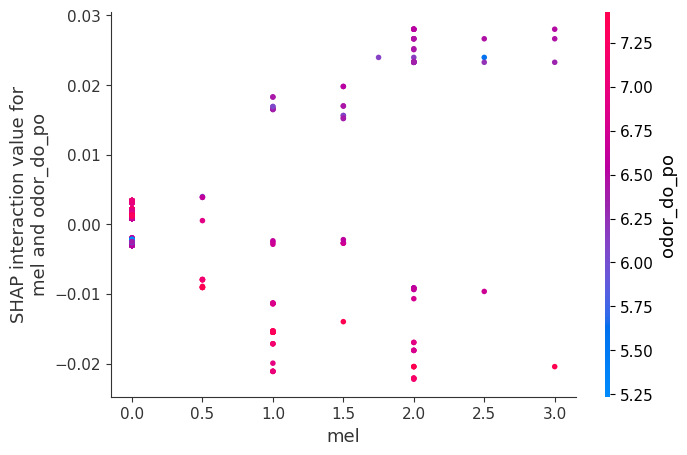

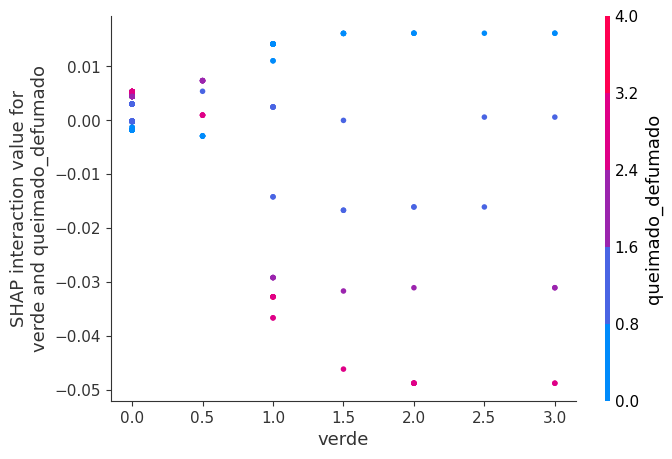

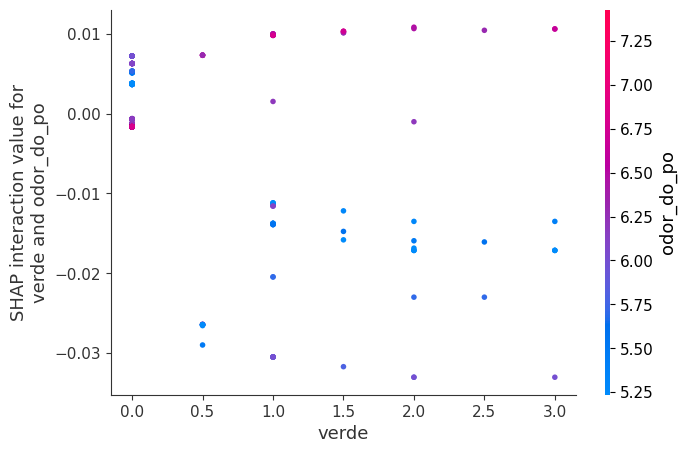

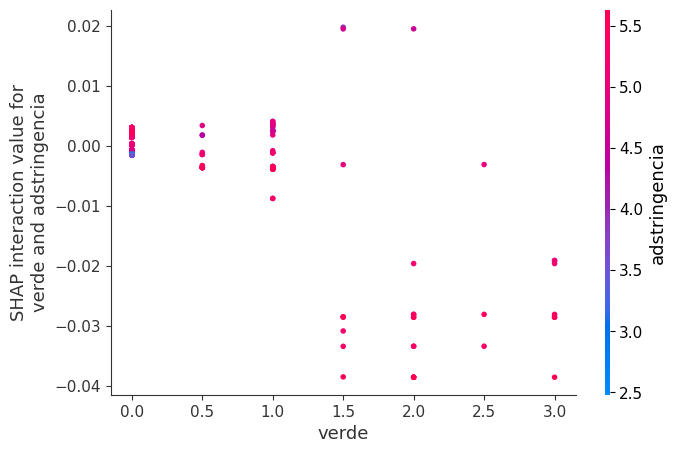

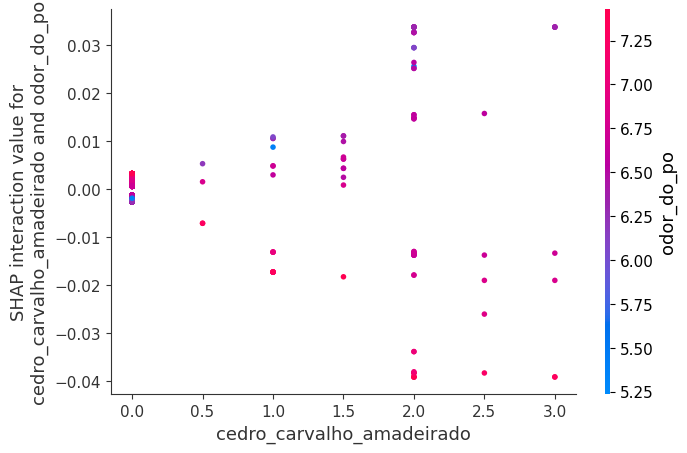

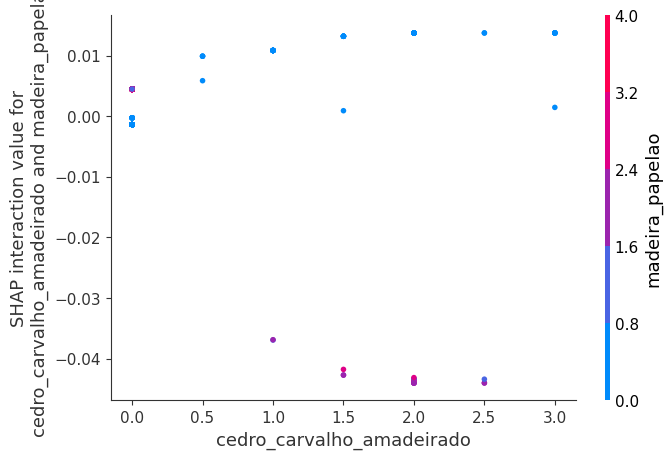

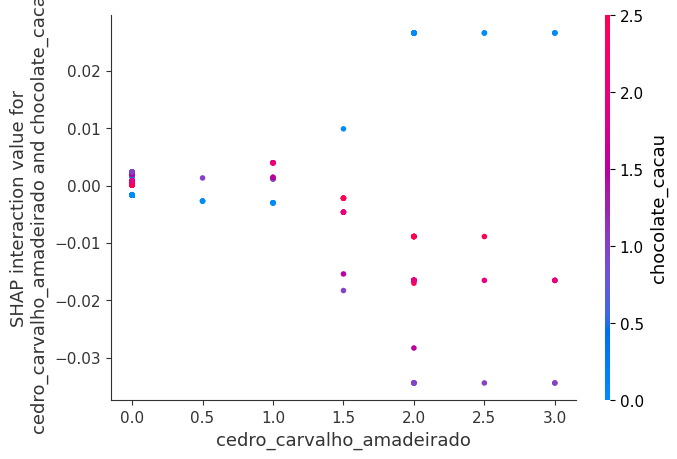

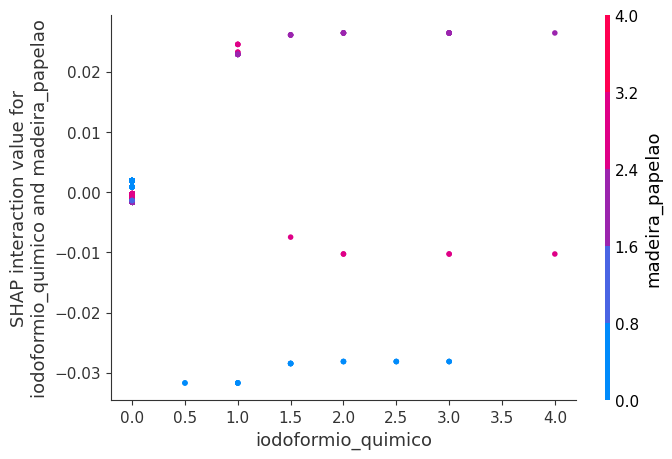

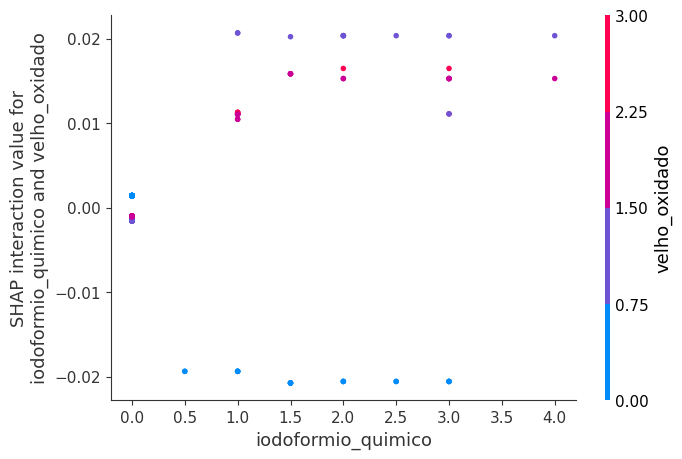

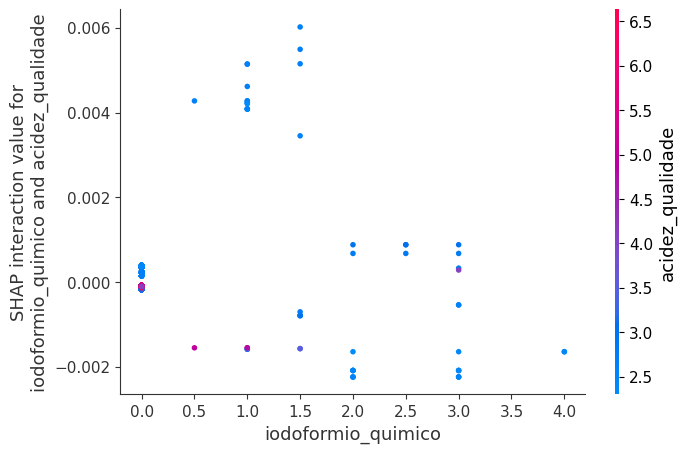

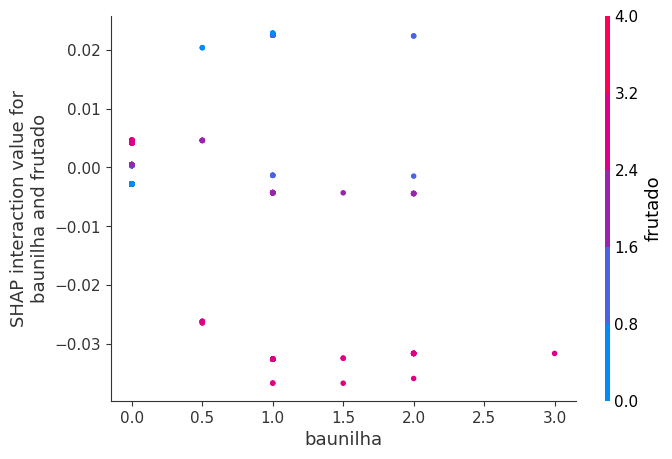

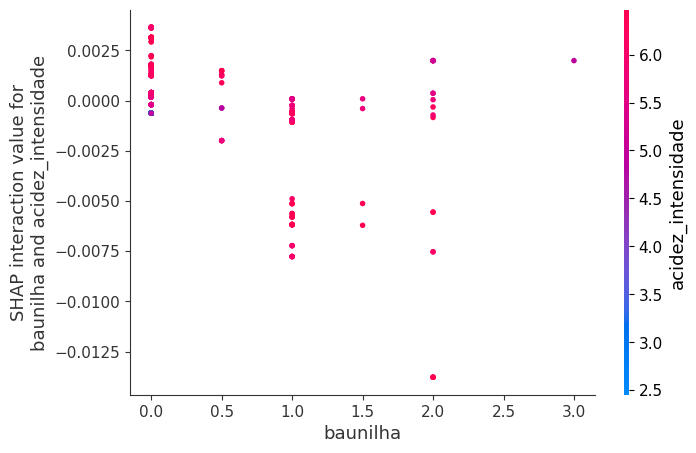

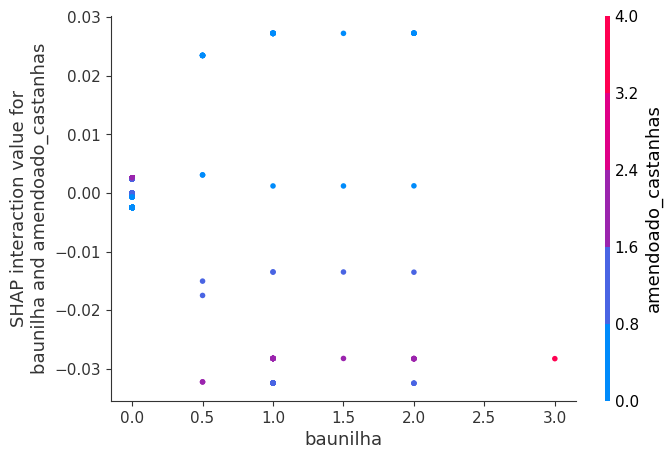

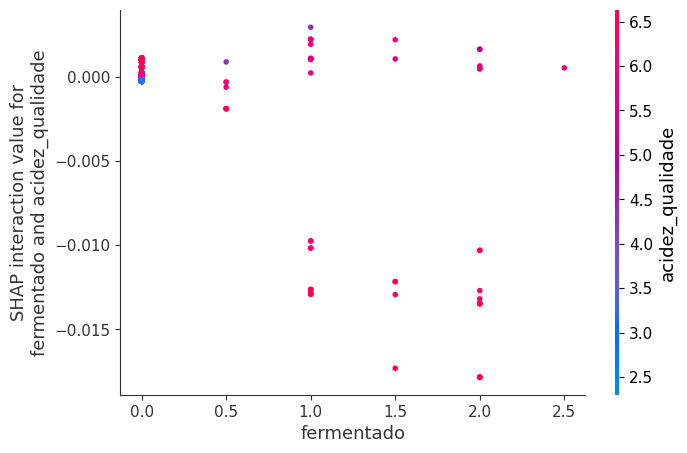

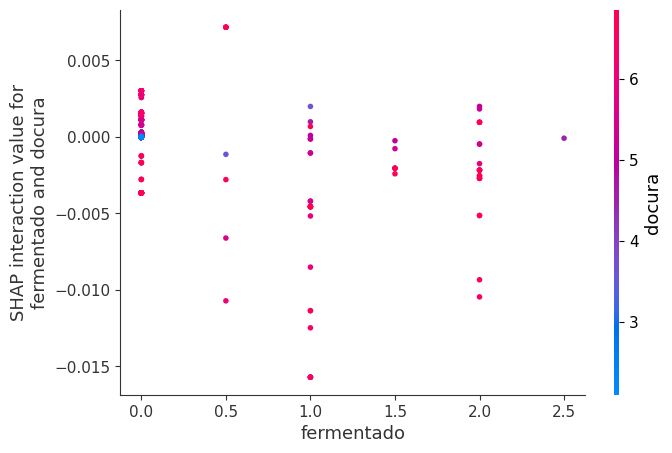

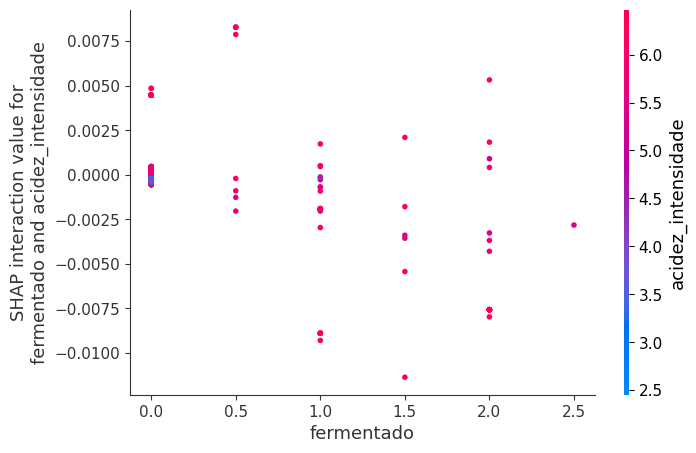

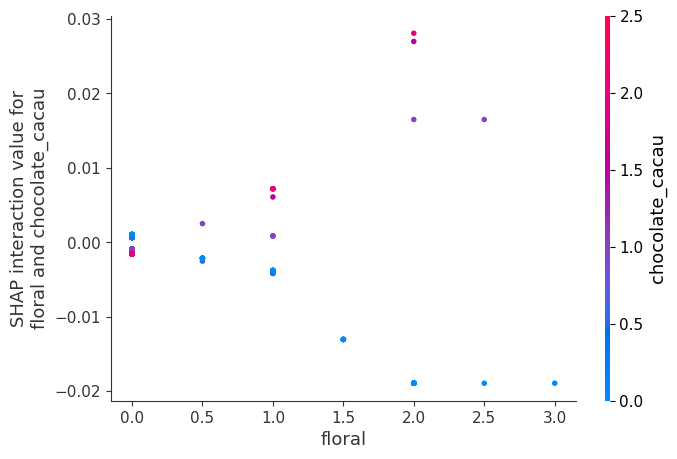

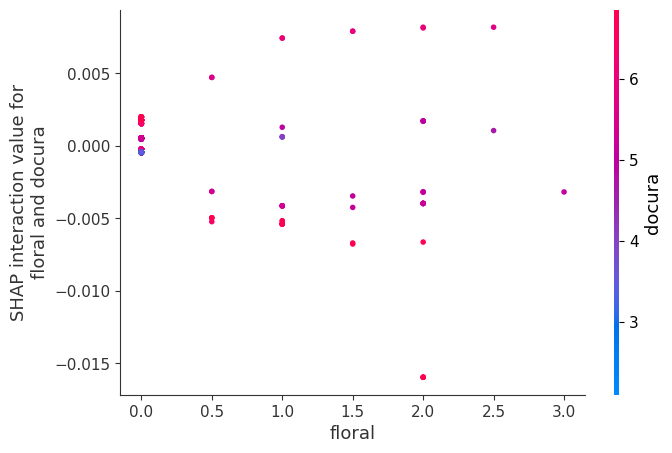

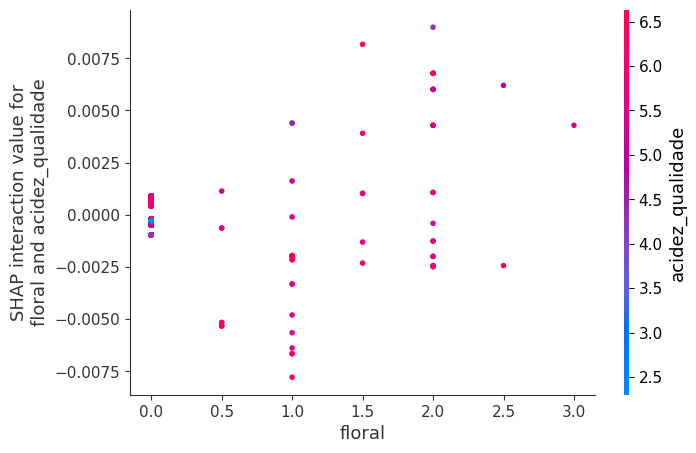

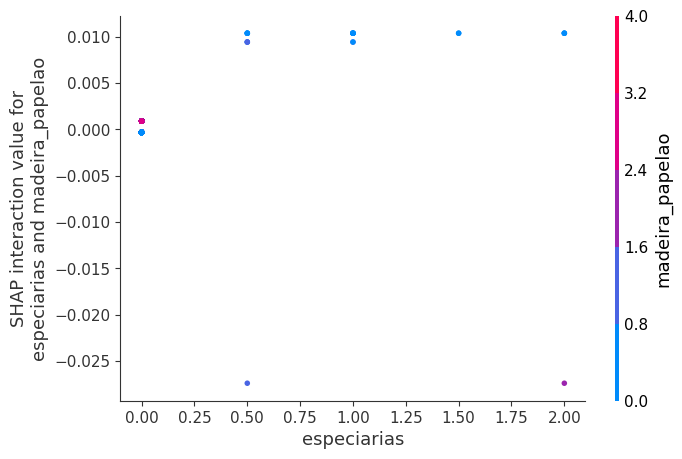

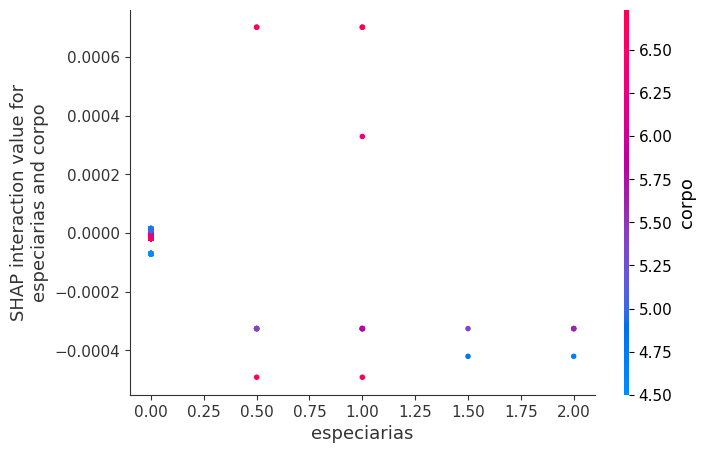

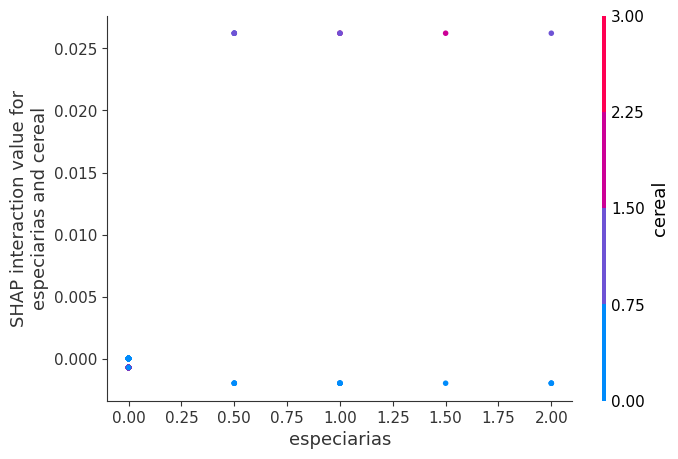

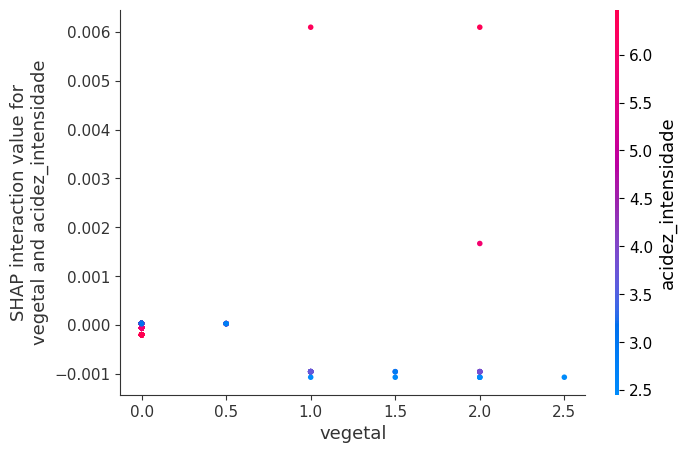

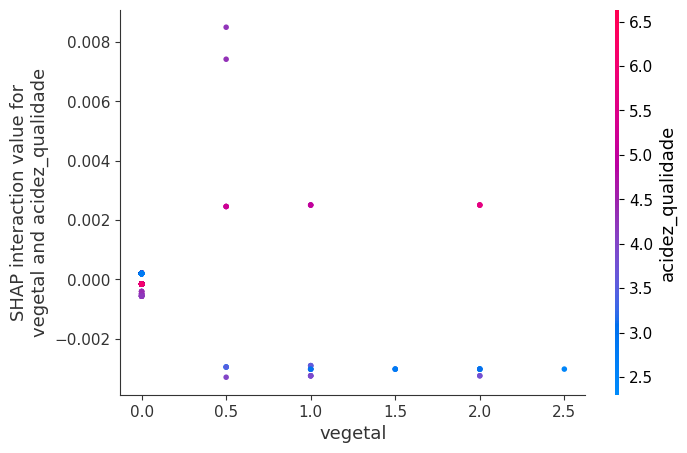

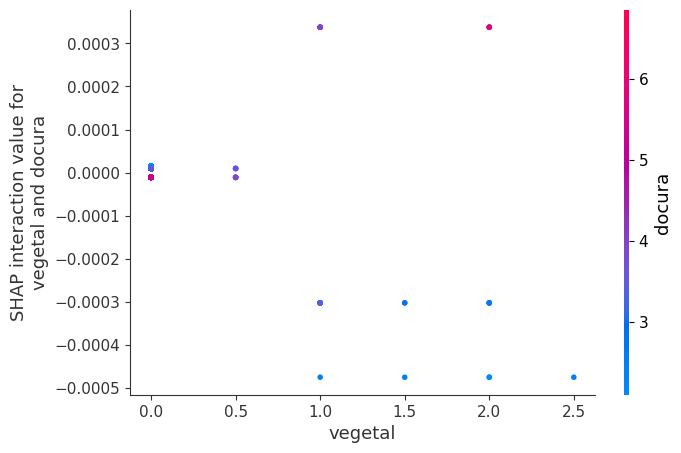

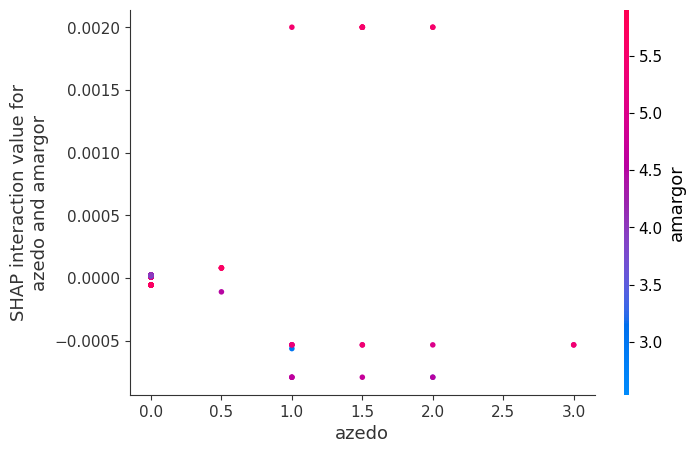

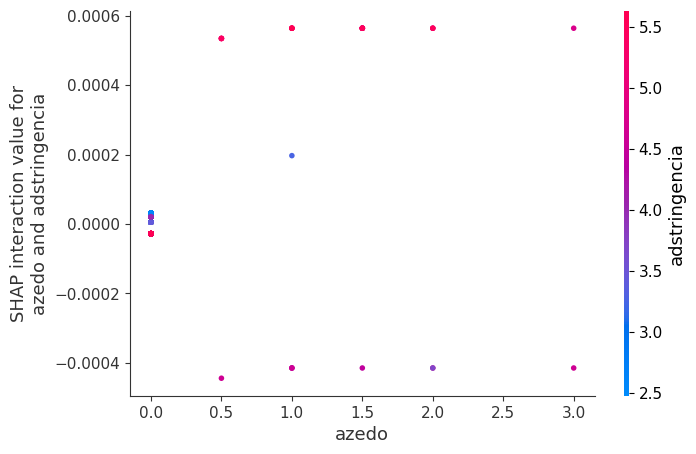

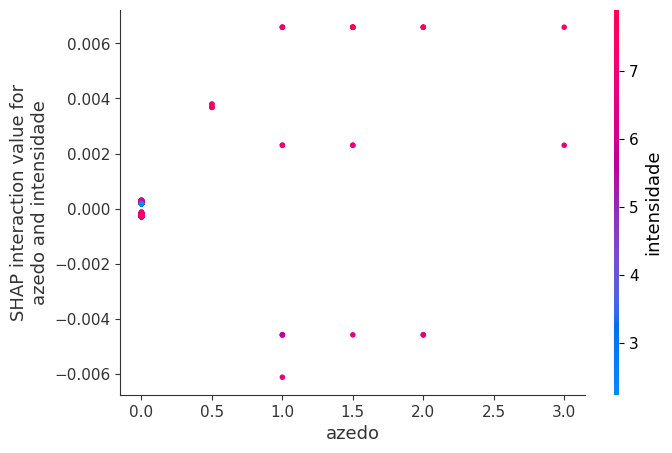

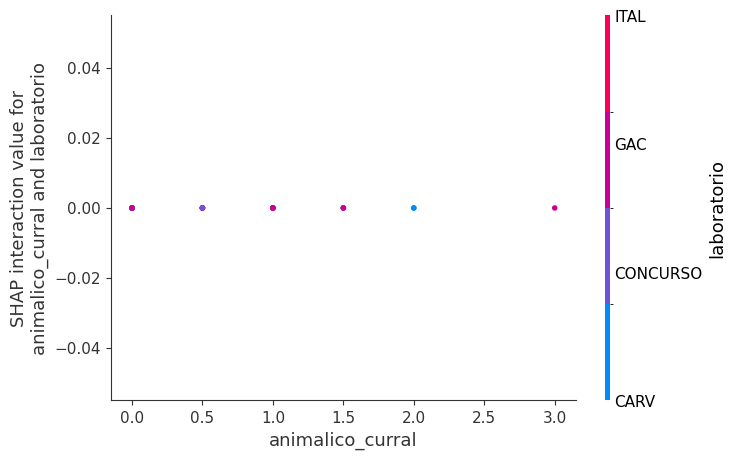

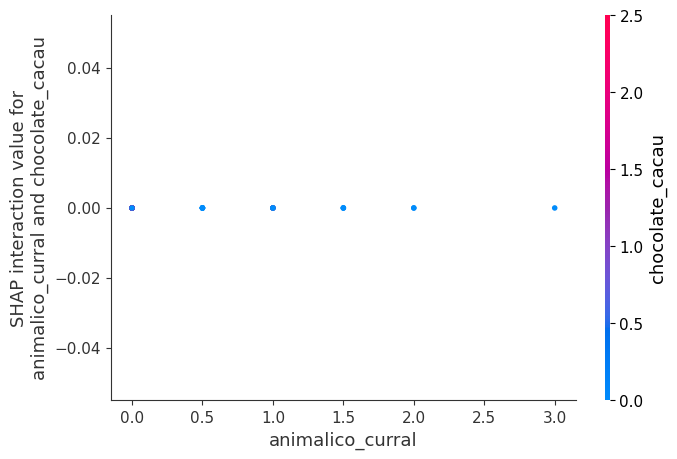

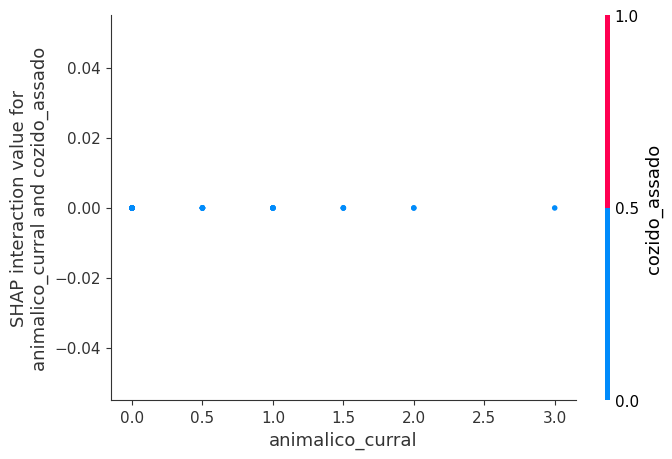

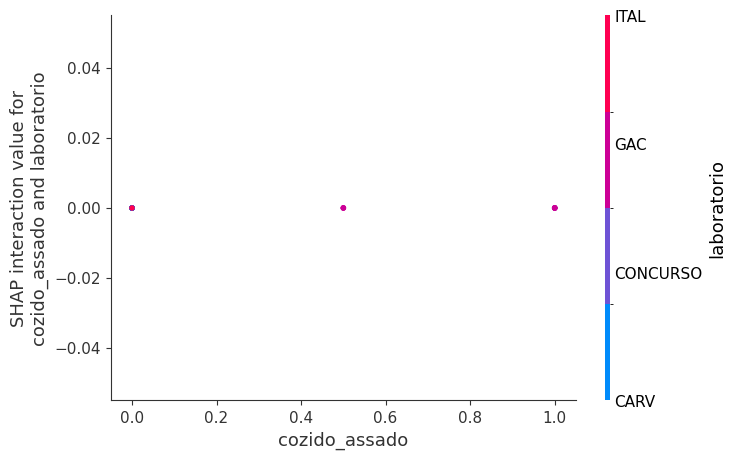

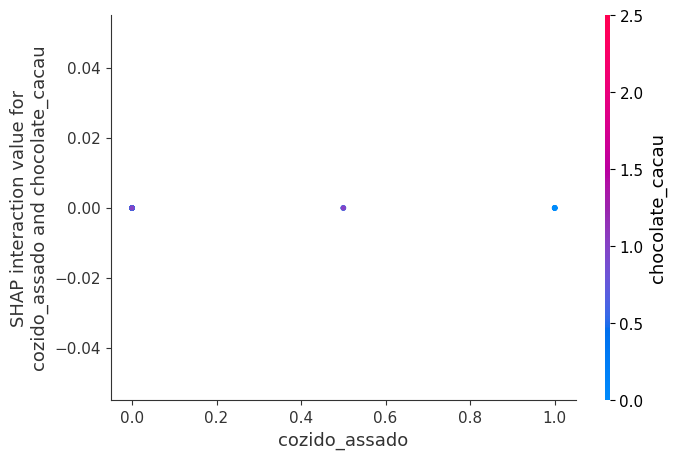

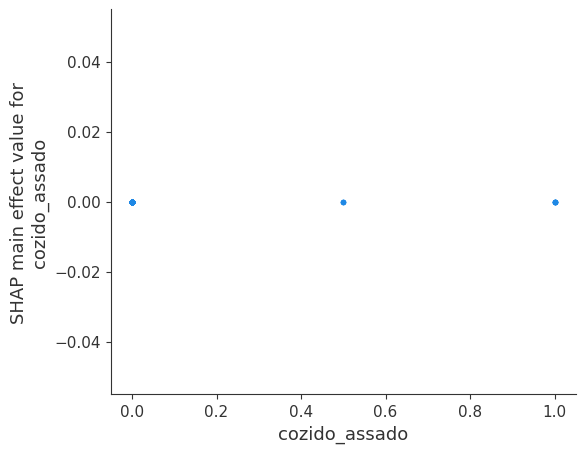

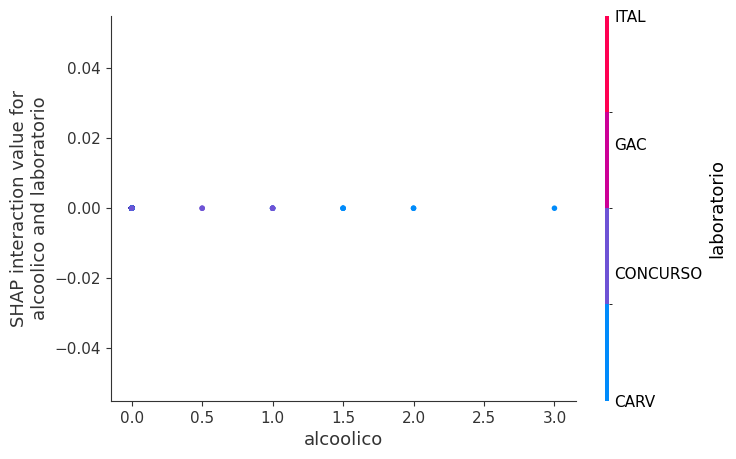

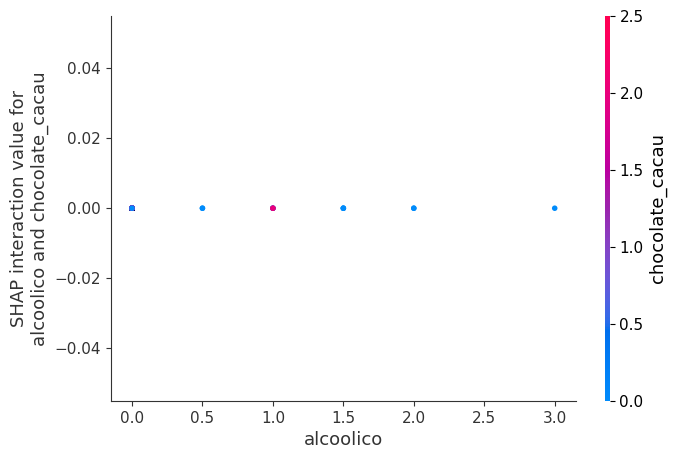

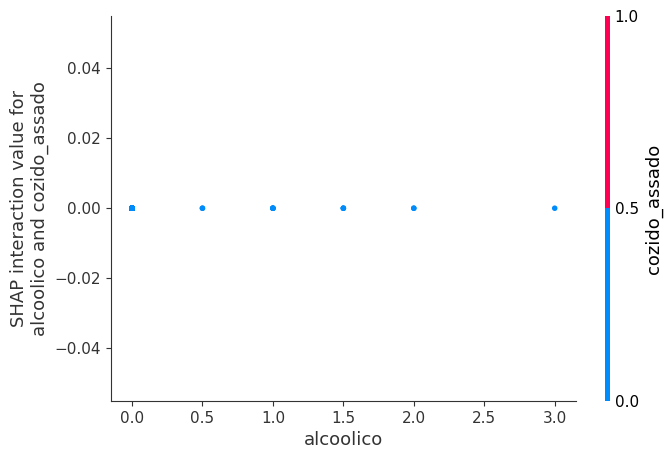

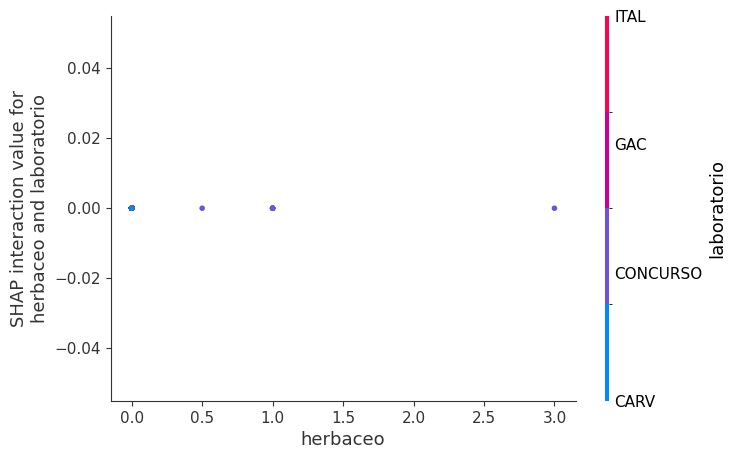

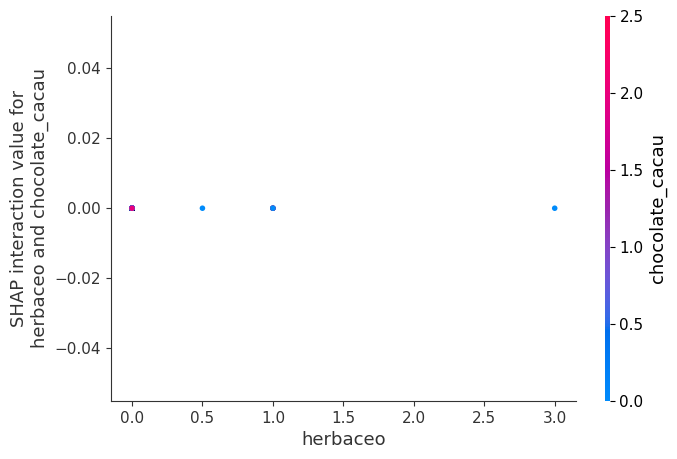

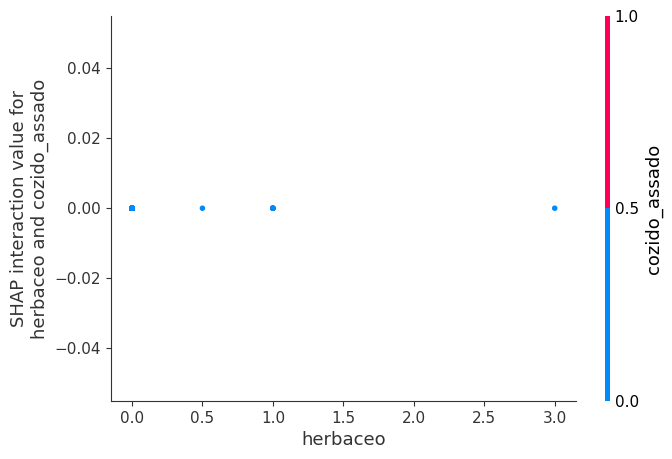

In [22]:
for col in int_imp.index.values:
   for i in range(3):
      index = int_order[col][i]
      int_var = trn_data.columns[index]
      
      shap.dependence_plot((col,int_var) , shap_interaction_values, trn_data)

In [23]:
int_var

'cozido_assado'

In [24]:
shap_vals

array([[-0.00687201,  0.00386716, -0.04007195, ..., -0.00905701,
        -0.0018978 ,  0.        ],
       [ 0.00090582,  0.00357334, -0.03069167, ..., -0.00700846,
        -0.00225796,  0.        ],
       [ 0.00643704,  0.00190593,  0.01524508, ..., -0.00637879,
        -0.00243796,  0.        ],
       ...,
       [-0.0012848 , -0.0104595 , -0.01370189, ..., -0.00982798,
        -0.0030448 ,  0.        ],
       [ 0.03264571, -0.00141097,  0.00422814, ...,  0.04384099,
        -0.00234277,  0.        ],
       [ 0.03349086,  0.00087365, -0.02416872, ...,  0.07950954,
         0.00364351,  0.        ]])